# Modeling Wisconsin Teacher Compensation:

By analyzing public data on teacher compensation and school district data I aim to build a model that could be used  by teachers, district officials, and policy makers who want to know what factors most impact teacher compensation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import neighbors
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from scipy.stats import bartlett
from scipy.stats import levene
from statsmodels.tsa.stattools import acf

import warnings
warnings.filterwarnings('ignore')

# Loading in the data: 

This first data set is taken from https://dpi.wi.gov/cst/data-collections/staff/published-data and includes compensation information for all staff in Wisconsin public schools in 2016.

In [2]:
df = pd.read_excel(r'/Users/steveangeli/Desktop/Thinkful Data Science Projects/Machine_Learning_Capstone/AllStaff2016rev11-01-16.xlsx', sheet_name='All Staff 2015-2016')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49
0,NaN,2015-2016 WISEstaff All Staff File,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,ID Nbr,Last Name,First Name,File Number,Gndr,RaceEthn,Birth Year,High Degree,Year Session,Cntrct Days,Local Exp,Total Exp,Tot Salary,Tot Fringe,Staff Cat,Hire Agncy Cd,Work Agncy Cd,Hire Agncy Typ,School Cd,Position Cd,Assgn Area Cd,Low Grd,High Grd,LG Sort Cd,HG Sort Cd,Bilingual,Assgn FTE,Work Location Name,School Name,Grd Level,CESA Number,Cnty Nbr,Cnty Name,Work Agncy Typ,School Mailing Address1,School Mailing Address2,School Shipping Address1,School Shipping Address2,Mail City,Mail St,Mail Zip Cd,Ship City,Ship St,Ship Zip Cd,Phone,Admin Name,Former Last Nm,LT Sub,Sub Cntrctd
3,NaN,000667675,Abel,Nancy,64679,F,W,1955,4,2016R,187,11,11,50000,16489,1,0007,0007,03,0020,53,0050,K4,K4,10,10,N,100,Abbotsford Sch Dist,Abbotsford Elementary,6,10,10,Clark County,04,PO Box A,Abbotsford WI 54405-0901,510 W Hemlock St,Abbotsford WI 54405,Abbotsford,WI,54405-0901,Abbotsford,WI,54405,715-223-4281,Gary Gunderson,,N,N
4,NaN,000629989,Anderson,Shana,,F,W,1978,,2016R,0,NaN,NaN,0,0,3,0007,0007,03,0020,98,9073,K4,05,10,36,,NaN,Abbotsford Sch Dist,Abbotsford Elementary,6,10,10,Clark County,04,PO Box A,Abbotsford WI 54405-0901,510 W Hemlock St,Abbotsford WI 54405,Abbotsford,WI,54405-0901,Abbotsford,WI,54405,715-223-4281,Gary Gunderson,,,


In [3]:
# Drop the first two rows and the first empty column names.

df.drop(df.index[[0,1]], inplace=True)
df.drop(df.columns[0], axis=1, inplace=True)

# Get the column names from the first row and give them to the dataframe.

column_names = []
for i in range(len(df.columns)):
    column_names.append(df.iloc[0,i])

df.columns = column_names

# Now drop that first row. 

df.drop(df.index[[0]], inplace=True)
df.head()

,ID Nbr,Last Name,First Name,File Number,Gndr,RaceEthn,Birth Year,High Degree,Year Session,Cntrct Days,Local Exp,Total Exp,Tot Salary,Tot Fringe,Staff Cat,Hire Agncy Cd,Work Agncy Cd,Hire Agncy Typ,School Cd,Position Cd,Assgn Area Cd,Low Grd,High Grd,LG Sort Cd,HG Sort Cd,Bilingual,Assgn FTE,Work Location Name,School Name,Grd Level,CESA Number,Cnty Nbr,Cnty Name,Work Agncy Typ,School Mailing Address1,School Mailing Address2,School Shipping Address1,School Shipping Address2,Mail City,Mail St,Mail Zip Cd,Ship City,Ship St,Ship Zip Cd,Phone,Admin Name,Former Last Nm,LT Sub,Sub Cntrctd
3,000667675,Abel,Nancy,64679,F,W,1955,4,2016R,187,11,11,50000,16489,1,0007,0007,03,0020,53,0050,K4,K4,10,10,N,100,Abbotsford Sch Dist,Abbotsford Elementary,6,10,10,Clark County,04,PO Box A,Abbotsford WI 54405-0901,510 W Hemlock St,Abbotsford WI 54405,Abbotsford,WI,54405-0901,Abbotsford,WI,54405,715-223-4281,Gary Gunderson,,N,N
4,000629989,Anderson,Shana,,F,W,1978,,2016R,0,NaN,NaN,0,0,3,0007,0007,03,0020,98,9073,K4,05,10,36,,NaN,Abbotsford Sch Dist,Abbotsford Elementary,6,10,10,Clark County,04,PO Box A,Abbotsford WI 54405-0901,510 W Hemlock St,Abbotsford WI 54405,Abbotsford,WI,54405-0901,Abbotsford,WI,54405,715-223-4281,Gary Gunderson,,,
5,000686793,Bittner,Sarah,708452,F,W,1973,,2016R,0,NaN,NaN,0,0,3,0007,0007,03,0020,97,0907,K4,05,10,36,,49,Abbotsford Sch Dist,Abbotsford Elementary,6,10,10,Clark County,04,PO Box A,Abbotsford WI 54405-0901,510 W Hemlock St,Abbotsford WI 54405,Abbotsford,WI,54405-0901,Abbotsford,WI,54405,715-223-4281,Gary Gunderson,,,N
6,000574087,Blasel,Jennifer,,F,W,1977,,2016R,0,NaN,NaN,0,0,3,0007,0007,03,0020,97,0907,K4,05,10,36,,49,Abbotsford Sch Dist,Abbotsford Elementary,6,10,10,Clark County,04,PO Box A,Abbotsford WI 54405-0901,510 W Hemlock St,Abbotsford WI 54405,Abbotsford,WI,54405-0901,Abbotsford,WI,54405,715-223-4281,Gary Gunderson,,,N
7,000687904,Bohl,Jessica,686422,F,H,1977,5,2016R,187,9,9,48104,23853,1,0007,0007,03,0020,53,0395,KG,05,16,36,N,50,Abbotsford Sch Dist,Abbotsford Elementary,6,10,10,Clark County,04,PO Box A,Abbotsford WI 54405-0901,510 W Hemlock St,Abbotsford WI 54405,Abbotsford,WI,54405-0901,Abbotsford,WI,54405,715-223-4281,Gary Gunderson,,N,N


Now I want to add in a bit more context data from which I'll pull out each district's total enrollment. I'm curious if district size will impact teacher compensation, and in which direction.

This data is found here: https://dpi.wi.gov/cst/data-collections/student/ises/published-data/excel

In [4]:
df2 = pd.read_excel(r'/Users/steveangeli/Desktop/Thinkful Data Science Projects/Machine_Learning_Capstone/PEM16.xlsx', sheet_name='PEM16')
df2.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29
0,NaN,2015-2016 Public Enrollment Master (PEM),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,State of Wisconsin Total:,5062,5344,16439,16277,39678,42530,47466,50381,350,378,298587,319355,13043,12910,867800
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,American Indian or Alaska Native (I),NaN,Asian (A),NaN,Black or African American (B),NaN,Hispanic / Latino (H),NaN,Native Hawaiian or Other \nPacific Islander (P),NaN,White (W),NaN,Two or More \nRaces (T),NaN,NaN
3,NaN,Year,District,District Code,Dist Type,Cty Code,County Name,CESA,WTCS,Locale Code,Sch Code,School,Grade,Gr. Cat.,Gr. Sort,I Female,I Male,A Female,A Male,B Female,B Male,H Female,H Male,P Female,P Male,W Female,W Male,T Female,T Male,Total
4,NaN,2016,Abbotsford Sch Dist,0007,03,10,Clark,10,NC,41,0020,Abbotsford Elementary,01,E,20,0,0,0,0,2,0,12,11,0,0,7,18,0,0,50


In [5]:
# Drop the first three rows and the first empty column names.

df2.drop(df2.index[[0,1,2]], inplace=True)
df2.drop(df2.columns[0], axis=1, inplace=True)
df2.drop(df2.columns[1], axis=1, inplace=True)

column_names = []
for i in range(len(df2.columns)):
    column_names.append(df2.iloc[0,i])

df2.columns = column_names
df2.drop(df2.index[[0]], inplace=True)

df2.head()

,Year,District Code,Dist Type,Cty Code,County Name,CESA,WTCS,Locale Code,Sch Code,School,Grade,Gr. Cat.,Gr. Sort,I Female,I Male,A Female,A Male,B Female,B Male,H Female,H Male,P Female,P Male,W Female,W Male,T Female,T Male,Total
4,2016,0007,03,10,Clark,10,NC,41,0020,Abbotsford Elementary,01,E,20,0,0,0,0,2,0,12,11,0,0,7,18,0,0,50
5,2016,0007,03,10,Clark,10,NC,41,0020,Abbotsford Elementary,02,E,24,0,1,0,1,0,0,8,15,0,0,11,13,0,0,49
6,2016,0007,03,10,Clark,10,NC,41,0020,Abbotsford Elementary,03,E,28,0,0,0,0,2,1,13,17,0,0,15,16,0,0,64
7,2016,0007,03,10,Clark,10,NC,41,0020,Abbotsford Elementary,04,E,32,0,0,0,0,0,0,13,10,0,0,11,20,0,0,54
8,2016,0007,03,10,Clark,10,NC,41,0020,Abbotsford Elementary,05,E,36,0,0,0,0,0,0,19,10,0,0,13,9,0,0,51


In [6]:
enrollment = df2.groupby(['District Code'])['Total'].sum()

# Reset the index in order to get the District Code as a column.
enrollment = enrollment.reset_index()
enrollment.head()

,District Code,Total
0,0007,713
1,0014,1568
2,0063,322
3,0070,723
4,0084,254


In [7]:
# Merge the enrollment data with the teacher dataframe on the district/hire agency codes.

df = pd.merge(df, enrollment, how='left', left_on='Work Agncy Cd', right_on='District Code')
df.head()

,ID Nbr,Last Name,First Name,File Number,Gndr,RaceEthn,Birth Year,High Degree,Year Session,Cntrct Days,Local Exp,Total Exp,Tot Salary,Tot Fringe,Staff Cat,Hire Agncy Cd,Work Agncy Cd,Hire Agncy Typ,School Cd,Position Cd,Assgn Area Cd,Low Grd,High Grd,LG Sort Cd,HG Sort Cd,Bilingual,Assgn FTE,Work Location Name,School Name,Grd Level,CESA Number,Cnty Nbr,Cnty Name,Work Agncy Typ,School Mailing Address1,School Mailing Address2,School Shipping Address1,School Shipping Address2,Mail City,Mail St,Mail Zip Cd,Ship City,Ship St,Ship Zip Cd,Phone,Admin Name,Former Last Nm,LT Sub,Sub Cntrctd,District Code,Total
0,000667675,Abel,Nancy,64679,F,W,1955,4,2016R,187,11,11,50000,16489,1,0007,0007,03,0020,53,0050,K4,K4,10,10,N,100,Abbotsford Sch Dist,Abbotsford Elementary,6,10,10,Clark County,04,PO Box A,Abbotsford WI 54405-0901,510 W Hemlock St,Abbotsford WI 54405,Abbotsford,WI,54405-0901,Abbotsford,WI,54405,715-223-4281,Gary Gunderson,,N,N,0007,713.0
1,000629989,Anderson,Shana,,F,W,1978,,2016R,0,NaN,NaN,0,0,3,0007,0007,03,0020,98,9073,K4,05,10,36,,NaN,Abbotsford Sch Dist,Abbotsford Elementary,6,10,10,Clark County,04,PO Box A,Abbotsford WI 54405-0901,510 W Hemlock St,Abbotsford WI 54405,Abbotsford,WI,54405-0901,Abbotsford,WI,54405,715-223-4281,Gary Gunderson,,,,0007,713.0
2,000686793,Bittner,Sarah,708452,F,W,1973,,2016R,0,NaN,NaN,0,0,3,0007,0007,03,0020,97,0907,K4,05,10,36,,49,Abbotsford Sch Dist,Abbotsford Elementary,6,10,10,Clark County,04,PO Box A,Abbotsford WI 54405-0901,510 W Hemlock St,Abbotsford WI 54405,Abbotsford,WI,54405-0901,Abbotsford,WI,54405,715-223-4281,Gary Gunderson,,,N,0007,713.0
3,000574087,Blasel,Jennifer,,F,W,1977,,2016R,0,NaN,NaN,0,0,3,0007,0007,03,0020,97,0907,K4,05,10,36,,49,Abbotsford Sch Dist,Abbotsford Elementary,6,10,10,Clark County,04,PO Box A,Abbotsford WI 54405-0901,510 W Hemlock St,Abbotsford WI 54405,Abbotsford,WI,54405-0901,Abbotsford,WI,54405,715-223-4281,Gary Gunderson,,,N,0007,713.0
4,000687904,Bohl,Jessica,686422,F,H,1977,5,2016R,187,9,9,48104,23853,1,0007,0007,03,0020,53,0395,KG,05,16,36,N,50,Abbotsford Sch Dist,Abbotsford Elementary,6,10,10,Clark County,04,PO Box A,Abbotsford WI 54405-0901,510 W Hemlock St,Abbotsford WI 54405,Abbotsford,WI,54405-0901,Abbotsford,WI,54405,715-223-4281,Gary Gunderson,,N,N,0007,713.0


In [8]:
# Rename the District Enrollment column.
df.rename(columns={"Total": "District Enrollment"}, inplace=True)

# Recast the District Code as an int and then as a string to get it into the format I want to use.
district_code = df['Work Agncy Cd'].astype(int)
district_code = district_code.astype(str)
df['Work Agncy Cd'] = district_code

But perhaps district size alone isn't a factor, but rather depends on each district's per-pupil revenue and aid. Some wealthier districts raise more revenue within their district, and some poorer districts receive more aid from the state aid fund. I'll investigate the influence of these factors on teacher compensation.

This data is found here: https://dpi.wi.gov/sfs/reporting/safr/budget/data-download#Budget_2016-2017

In [9]:
df3 = pd.read_excel(r'/Users/steveangeli/Desktop/Thinkful Data Science Projects/Machine_Learning_Capstone/revlim17_prepop_mar10.xlsx', sheet_name='Data')
df3.head()

,1,NAME,BASEREV,BASEAID,COMAID_PY_FILE,HIPOV_OFFSET_PY,LEVY10C_PY,LEVY38C_PY,LEVY41C_PY,AIDPENPY,NONREXMP,SUMM13,SUMM1340,fte3rd13,fte3f13s,SUMM14,SUMM1440,fte3rd14,fte3f14s,SUMM15,SUMM1540,fte3rd15,fte3f15s,SUMM16,SUMM1640,fte3rd16,fte3f16s,UNUSEDPY,REFRCY,REFNRCY,OCTAID,TRGAIDCY,hipov_cy,CCPERMEM,service,Reorg,impex_cy,total_energy_exempt_cy,COMPVAL,TIFOUTCY,TIF_COMP,EXCLMESS,LEVY10C_CY,simlevy38c_cy,simlevy39c_cy,LEVY41C_CY,SPECLEVY_cy,LEVY80C_CY,CHGBACK_CY,LEVY48C_CY,LINE7XTR_CY,UNCTOEPY,EXCLAID,REFRESTX,comserv_penalty_cy,ENV_REMEDIATE_CY,INCOMING_CHOICE_CY,RL_EX_1415,FUND10_EXP_1506_1415,JANJUN15,JULDEC15,EE_EXEMPT_1516_ND,FUND10_EXP_1506_1516,MESS,FLAG,EE_EXEMPT_1617_D,EE_EXEMPT_1617_ND,UTILITY_SAVINGS_1617,LINE6_SNSP_FALL2016
0,Code,Use arrow at right to select district.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7,Abbotsford,6717314.0,5337015.0,12535.0,46648.0,1379354.0,0.0,0.0,0.0,58238.0,31.0,12.0,663.0,675.0,34.0,14.0,673.0,687.0,30.0,12.0,677.0,689.0,29.0,12.0,708.0,720.0,0.0,0.0,0.0,5812981.0,5766333.0,46648.0,0.0,35486.0,0.0,0.0,0.0,918000.0,2.109099e+08,2.118279e+08,"PRIOR TO SETTING LEVY, DOUBLE CHECK THAT YOU A...",1050722.0,0.0,627469.0,0.0,0.0,0.0,0.0,0.0,0.0,20004.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0
2,14,Adams-Friendship Area,15154132.0,4478838.0,21212.0,110036.0,11081033.0,63075.0,0.0,0.0,600062.0,58.0,23.0,1643.0,1666.0,53.0,21.0,1630.0,1651.0,51.0,20.0,1584.0,1604.0,88.0,35.0,1604.0,1639.0,0.0,0.0,175000.0,4770933.0,4660897.0,110036.0,0.0,0.0,0.0,0.0,34834.0,489100.0,1.298605e+09,1.299094e+09,"PRIOR TO SETTING LEVY, DOUBLE CHECK THAT YOU A...",10436285.0,63075.0,1364285.0,0.0,0.0,131000.0,0.0,0.0,83170.0,1918.0,0.0,761.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,97415.0,0.0,62581.0,0.0
3,63,Albany,3950418.0,2288807.0,503.0,0.0,2353686.0,20817.0,0.0,0.0,713395.0,8.0,3.0,430.0,433.0,8.0,3.0,420.0,423.0,10.0,4.0,410.0,414.0,11.0,4.0,416.0,420.0,0.0,800000.0,0.0,2342104.0,2342104.0,0.0,0.0,16064.0,0.0,0.0,0.0,57400.0,2.278102e+08,2.278676e+08,"PRIOR TO SETTING LEVY, DOUBLE CHECK THAT YOU A...",2428042.0,39608.0,382531.0,0.0,0.0,20000.0,0.0,0.0,37356.0,6639.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0
4,70,Algoma,6595254.0,4063655.0,8432.0,0.0,2532398.0,0.0,0.0,9231.0,0.0,16.0,6.0,678.0,684.0,16.0,6.0,706.0,712.0,21.0,8.0,730.0,738.0,23.0,9.0,726.0,735.0,0.0,0.0,0.0,4059987.0,4059987.0,0.0,0.0,0.0,0.0,0.0,0.0,704400.0,3.488251e+08,3.495295e+08,"PRIOR TO SETTING LEVY, DOUBLE CHECK THAT YOU A...",2686536.0,0.0,336103.0,0.0,0.0,160000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0


In [10]:
# Select only the first 3 columns and drop the first row. 
df3 = df3.iloc[:, :4]
df3.drop(df3.index[[0]], inplace=True)

# Rename the first column.
df3.rename(columns={1: "District Code"}, inplace=True)

# Recast the District Code into the format of the main df. 
df3_district_code = df3['District Code'].astype(str)
df3['District Code'] = df3_district_code

# Merge with main df.
df = pd.merge(df, df3, how='left', left_on='Work Agncy Cd', right_on='District Code')
df.head()

,ID Nbr,Last Name,First Name,File Number,Gndr,RaceEthn,Birth Year,High Degree,Year Session,Cntrct Days,Local Exp,Total Exp,Tot Salary,Tot Fringe,Staff Cat,Hire Agncy Cd,Work Agncy Cd,Hire Agncy Typ,School Cd,Position Cd,Assgn Area Cd,Low Grd,High Grd,LG Sort Cd,HG Sort Cd,Bilingual,Assgn FTE,Work Location Name,School Name,Grd Level,CESA Number,Cnty Nbr,Cnty Name,Work Agncy Typ,School Mailing Address1,School Mailing Address2,School Shipping Address1,School Shipping Address2,Mail City,Mail St,Mail Zip Cd,Ship City,Ship St,Ship Zip Cd,Phone,Admin Name,Former Last Nm,LT Sub,Sub Cntrctd,District Code_x,District Enrollment,District Code_y,NAME,BASEREV,BASEAID
0,000667675,Abel,Nancy,64679,F,W,1955,4,2016R,187,11,11,50000,16489,1,0007,7,03,0020,53,0050,K4,K4,10,10,N,100,Abbotsford Sch Dist,Abbotsford Elementary,6,10,10,Clark County,04,PO Box A,Abbotsford WI 54405-0901,510 W Hemlock St,Abbotsford WI 54405,Abbotsford,WI,54405-0901,Abbotsford,WI,54405,715-223-4281,Gary Gunderson,,N,N,0007,713.0,7,Abbotsford,6717314.0,5337015.0
1,000629989,Anderson,Shana,,F,W,1978,,2016R,0,NaN,NaN,0,0,3,0007,7,03,0020,98,9073,K4,05,10,36,,NaN,Abbotsford Sch Dist,Abbotsford Elementary,6,10,10,Clark County,04,PO Box A,Abbotsford WI 54405-0901,510 W Hemlock St,Abbotsford WI 54405,Abbotsford,WI,54405-0901,Abbotsford,WI,54405,715-223-4281,Gary Gunderson,,,,0007,713.0,7,Abbotsford,6717314.0,5337015.0
2,000686793,Bittner,Sarah,708452,F,W,1973,,2016R,0,NaN,NaN,0,0,3,0007,7,03,0020,97,0907,K4,05,10,36,,49,Abbotsford Sch Dist,Abbotsford Elementary,6,10,10,Clark County,04,PO Box A,Abbotsford WI 54405-0901,510 W Hemlock St,Abbotsford WI 54405,Abbotsford,WI,54405-0901,Abbotsford,WI,54405,715-223-4281,Gary Gunderson,,,N,0007,713.0,7,Abbotsford,6717314.0,5337015.0
3,000574087,Blasel,Jennifer,,F,W,1977,,2016R,0,NaN,NaN,0,0,3,0007,7,03,0020,97,0907,K4,05,10,36,,49,Abbotsford Sch Dist,Abbotsford Elementary,6,10,10,Clark County,04,PO Box A,Abbotsford WI 54405-0901,510 W Hemlock St,Abbotsford WI 54405,Abbotsford,WI,54405-0901,Abbotsford,WI,54405,715-223-4281,Gary Gunderson,,,N,0007,713.0,7,Abbotsford,6717314.0,5337015.0
4,000687904,Bohl,Jessica,686422,F,H,1977,5,2016R,187,9,9,48104,23853,1,0007,7,03,0020,53,0395,KG,05,16,36,N,50,Abbotsford Sch Dist,Abbotsford Elementary,6,10,10,Clark County,04,PO Box A,Abbotsford WI 54405-0901,510 W Hemlock St,Abbotsford WI 54405,Abbotsford,WI,54405-0901,Abbotsford,WI,54405,715-223-4281,Gary Gunderson,,N,N,0007,713.0,7,Abbotsford,6717314.0,5337015.0


Lastly I want to add in the context of whether the district is considered a high-poverty district and whether
that has any influence on teacher compensation. This isn't poverty based on the per-pupil revenue or aid received but rather a reflection of the student population being served.

This data is found here: https://dpi.wi.gov/sfs/aid/categorical/aid-high-poverty-districts

In [11]:
df4 = pd.read_excel(r'/Users/steveangeli/Desktop/Thinkful Data Science Projects/Machine_Learning_Capstone/High Poverty Aid FY16_FY17_publish.xlsx')
df4.head(10)

,HIGH POVERTY AID FOR 2015-16 and 2016-17 FISCAL YEARS,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,Based on 2014-15 3rd Friday Enrollment (ISES P...,NaN,NaN,NaN,NaN,NaN,NaN
1,"Per Statutes s.121.136 and 121.90(2), Wis. Sta...",NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,2014-15 3rd Friday Enrollment (ISES Pupils),2014-15 ISES ED Pupils,2014-15 Aid Membership (FTE),2014-15 %\nFree and\n Reduced -\n ROUNDED,FY16/FY17 High Poverty Aid Eligibility
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,7,Abbotsford,718,477,705,0.66,46648
6,14,Adams-Friendship Area,1625,1198,1663,0.74,110036
7,91,Alma Center,660,378,613,0.57,40561
8,105,Almond-Bancroft,421,211,465,0.5,30768
9,140,Antigo,2434,1306,2464,0.54,163036


In [12]:
# Drop the first three rows.
df4.drop(df4.index[[0,1,2]], inplace=True)

# Scoop up the column names.
column_names = []
for i in range(len(df4.columns)):
    column_names.append(df4.iloc[0,i])

df4.columns = column_names

# Drop the first two rows. 
df4.drop(df4.index[[0,1]], inplace=True)

# Assign names to the first two columns.
df4.columns.values[0] = 'District Code'
df4.columns.values[1] = 'District Name'

# Get the columns we care about.
df4 = df4[['District Code', 'District Name', '2014-15 %\nFree and\n Reduced -\n ROUNDED']]
df4.head()

# Recast the District Code into the type we want.
df4_district_code = df4['District Code'].astype(str)
df4['District Code'] = df4_district_code
df4.head()

,District Code,District Name,2014-15 %\nFree and\n Reduced -\n ROUNDED
5,7,Abbotsford,0.66
6,14,Adams-Friendship Area,0.74
7,91,Alma Center,0.57
8,105,Almond-Bancroft,0.5
9,140,Antigo,0.54


In [13]:
# Merge with the main df.
df = pd.merge(df, df4, how='left', left_on='Work Agncy Cd', right_on='District Code')
df.head()

,ID Nbr,Last Name,First Name,File Number,Gndr,RaceEthn,Birth Year,High Degree,Year Session,Cntrct Days,Local Exp,Total Exp,Tot Salary,Tot Fringe,Staff Cat,Hire Agncy Cd,Work Agncy Cd,Hire Agncy Typ,School Cd,Position Cd,Assgn Area Cd,Low Grd,High Grd,LG Sort Cd,HG Sort Cd,Bilingual,Assgn FTE,Work Location Name,School Name,Grd Level,CESA Number,Cnty Nbr,Cnty Name,Work Agncy Typ,School Mailing Address1,School Mailing Address2,School Shipping Address1,School Shipping Address2,Mail City,Mail St,Mail Zip Cd,Ship City,Ship St,Ship Zip Cd,Phone,Admin Name,Former Last Nm,LT Sub,Sub Cntrctd,District Code_x,District Enrollment,District Code_y,NAME,BASEREV,BASEAID,District Code,District Name,2014-15 %\nFree and\n Reduced -\n ROUNDED
0,000667675,Abel,Nancy,64679,F,W,1955,4,2016R,187,11,11,50000,16489,1,0007,7,03,0020,53,0050,K4,K4,10,10,N,100,Abbotsford Sch Dist,Abbotsford Elementary,6,10,10,Clark County,04,PO Box A,Abbotsford WI 54405-0901,510 W Hemlock St,Abbotsford WI 54405,Abbotsford,WI,54405-0901,Abbotsford,WI,54405,715-223-4281,Gary Gunderson,,N,N,0007,713.0,7,Abbotsford,6717314.0,5337015.0,7,Abbotsford,0.66
1,000629989,Anderson,Shana,,F,W,1978,,2016R,0,NaN,NaN,0,0,3,0007,7,03,0020,98,9073,K4,05,10,36,,NaN,Abbotsford Sch Dist,Abbotsford Elementary,6,10,10,Clark County,04,PO Box A,Abbotsford WI 54405-0901,510 W Hemlock St,Abbotsford WI 54405,Abbotsford,WI,54405-0901,Abbotsford,WI,54405,715-223-4281,Gary Gunderson,,,,0007,713.0,7,Abbotsford,6717314.0,5337015.0,7,Abbotsford,0.66
2,000686793,Bittner,Sarah,708452,F,W,1973,,2016R,0,NaN,NaN,0,0,3,0007,7,03,0020,97,0907,K4,05,10,36,,49,Abbotsford Sch Dist,Abbotsford Elementary,6,10,10,Clark County,04,PO Box A,Abbotsford WI 54405-0901,510 W Hemlock St,Abbotsford WI 54405,Abbotsford,WI,54405-0901,Abbotsford,WI,54405,715-223-4281,Gary Gunderson,,,N,0007,713.0,7,Abbotsford,6717314.0,5337015.0,7,Abbotsford,0.66
3,000574087,Blasel,Jennifer,,F,W,1977,,2016R,0,NaN,NaN,0,0,3,0007,7,03,0020,97,0907,K4,05,10,36,,49,Abbotsford Sch Dist,Abbotsford Elementary,6,10,10,Clark County,04,PO Box A,Abbotsford WI 54405-0901,510 W Hemlock St,Abbotsford WI 54405,Abbotsford,WI,54405-0901,Abbotsford,WI,54405,715-223-4281,Gary Gunderson,,,N,0007,713.0,7,Abbotsford,6717314.0,5337015.0,7,Abbotsford,0.66
4,000687904,Bohl,Jessica,686422,F,H,1977,5,2016R,187,9,9,48104,23853,1,0007,7,03,0020,53,0395,KG,05,16,36,N,50,Abbotsford Sch Dist,Abbotsford Elementary,6,10,10,Clark County,04,PO Box A,Abbotsford WI 54405-0901,510 W Hemlock St,Abbotsford WI 54405,Abbotsford,WI,54405-0901,Abbotsford,WI,54405,715-223-4281,Gary Gunderson,,N,N,0007,713.0,7,Abbotsford,6717314.0,5337015.0,7,Abbotsford,0.66


Now that I have all this data, it's time to clean it up.

# Data Cleaning

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186665 entries, 0 to 186664
Data columns (total 58 columns):
ID Nbr                                    186665 non-null object
Last Name                                 186665 non-null object
First Name                                186665 non-null object
File Number                               186665 non-null object
Gndr                                      186665 non-null object
RaceEthn                                  186665 non-null object
Birth Year                                186665 non-null object
High Degree                               186665 non-null object
Year Session                              186665 non-null object
Cntrct Days                               186665 non-null object
Local Exp                                 105652 non-null object
Total Exp                                 105652 non-null object
Tot Salary                                186665 non-null object
Tot Fringe                                18

In [15]:
# There appear to be around 81,000 entries where Total Experience is null.
nans = df[df["Total Exp"].isnull()]

# And there are 81,013 entries who have 0 total reported salary. 
print(nans["Tot Salary"].value_counts())

# I'm going to drop the entries where the Total Experience is null because those folks don't have any compensation
# information to report. 

df = df.dropna(subset=['Total Exp'])
df.info()

0    81013
Name: Tot Salary, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 105652 entries, 0 to 186662
Data columns (total 58 columns):
ID Nbr                                    105652 non-null object
Last Name                                 105652 non-null object
First Name                                105652 non-null object
File Number                               105652 non-null object
Gndr                                      105652 non-null object
RaceEthn                                  105652 non-null object
Birth Year                                105652 non-null object
High Degree                               105652 non-null object
Year Session                              105652 non-null object
Cntrct Days                               105652 non-null object
Local Exp                                 105652 non-null object
Total Exp                                 105652 non-null object
Tot Salary                                105652 non-null object
To

In [16]:
# I only care about teachers, so let's see how many we're working with here compared to other positions. 
# Teachers are position code '53'.

df['Position Cd'].value_counts(ascending=False)

# We can see that most of the folks in this data set are teachers.

53    75611
98    10369
54     2281
84     2230
51     2125
55     1412
64     1391
87     1044
63      986
99      903
50      842
52      766
18      739
75      732
17      629
59      557
05      438
80      398
85      294
10      272
09      236
62      216
88      206
08      203
43      161
90      157
86      126
19       92
97       51
96       44
83       40
92       36
06       29
93       20
79       11
91        5
Name: Position Cd, dtype: int64

In [17]:
# Let's get rid of everybody else and focus just on teachers. 

teachers = df[df['Position Cd'] == '53']
teachers.head()

,ID Nbr,Last Name,First Name,File Number,Gndr,RaceEthn,Birth Year,High Degree,Year Session,Cntrct Days,Local Exp,Total Exp,Tot Salary,Tot Fringe,Staff Cat,Hire Agncy Cd,Work Agncy Cd,Hire Agncy Typ,School Cd,Position Cd,Assgn Area Cd,Low Grd,High Grd,LG Sort Cd,HG Sort Cd,Bilingual,Assgn FTE,Work Location Name,School Name,Grd Level,CESA Number,Cnty Nbr,Cnty Name,Work Agncy Typ,School Mailing Address1,School Mailing Address2,School Shipping Address1,School Shipping Address2,Mail City,Mail St,Mail Zip Cd,Ship City,Ship St,Ship Zip Cd,Phone,Admin Name,Former Last Nm,LT Sub,Sub Cntrctd,District Code_x,District Enrollment,District Code_y,NAME,BASEREV,BASEAID,District Code,District Name,2014-15 %\nFree and\n Reduced -\n ROUNDED
0,000667675,Abel,Nancy,64679,F,W,1955,4,2016R,187,11,11,50000,16489,1,0007,7,03,0020,53,0050,K4,K4,10,10,N,100,Abbotsford Sch Dist,Abbotsford Elementary,6,10,10,Clark County,04,PO Box A,Abbotsford WI 54405-0901,510 W Hemlock St,Abbotsford WI 54405,Abbotsford,WI,54405-0901,Abbotsford,WI,54405,715-223-4281,Gary Gunderson,,N,N,0007,713.0,7,Abbotsford,6717314.0,5337015.0,7,Abbotsford,0.66
4,000687904,Bohl,Jessica,686422,F,H,1977,5,2016R,187,9,9,48104,23853,1,0007,7,03,0020,53,0395,KG,05,16,36,N,50,Abbotsford Sch Dist,Abbotsford Elementary,6,10,10,Clark County,04,PO Box A,Abbotsford WI 54405-0901,510 W Hemlock St,Abbotsford WI 54405,Abbotsford,WI,54405-0901,Abbotsford,WI,54405,715-223-4281,Gary Gunderson,,N,N,0007,713.0,7,Abbotsford,6717314.0,5337015.0,7,Abbotsford,0.66
5,000616820,Booth,Jennifer,751580,F,W,1975,4,2016R,187,1,1,39281,22548,1,0007,7,03,0020,53,0050,01,01,20,20,N,100,Abbotsford Sch Dist,Abbotsford Elementary,6,10,10,Clark County,04,PO Box A,Abbotsford WI 54405-0901,510 W Hemlock St,Abbotsford WI 54405,Abbotsford,WI,54405-0901,Abbotsford,WI,54405,715-223-4281,Gary Gunderson,,N,N,0007,713.0,7,Abbotsford,6717314.0,5337015.0,7,Abbotsford,0.66
6,000641226,Bowers,Teresa,594902,F,W,1966,4,2016R,187,16,16,55765,8424,1,0007,7,03,0020,53,0050,KG,KG,16,16,N,100,Abbotsford Sch Dist,Abbotsford Elementary,6,10,10,Clark County,04,PO Box A,Abbotsford WI 54405-0901,510 W Hemlock St,Abbotsford WI 54405,Abbotsford,WI,54405-0901,Abbotsford,WI,54405,715-223-4281,Gary Gunderson,,N,N,0007,713.0,7,Abbotsford,6717314.0,5337015.0,7,Abbotsford,0.66
8,000595662,Cihlar,Matthew,659569,M,W,1979,5,2016R,187,2,2,51784,9213,1,0007,7,03,0020,53,0530,KG,05,16,36,N,50,Abbotsford Sch Dist,Abbotsford Elementary,6,10,10,Clark County,04,PO Box A,Abbotsford WI 54405-0901,510 W Hemlock St,Abbotsford WI 54405,Abbotsford,WI,54405-0901,Abbotsford,WI,54405,715-223-4281,Gary Gunderson,,N,N,0007,713.0,7,Abbotsford,6717314.0,5337015.0,7,Abbotsford,0.66


In [18]:
# I'm going to only want to look at folks who are 100% FTE teachers. Let's see how many of them there are. 

print(len(teachers[teachers['Assgn FTE'] == 100]))
teachers = teachers[teachers['Assgn FTE'] == 100]

45149


In [19]:
# Get rid of a bunch of unnecessary or duplicate info now.

unnecessary_columns = ['Last Name', 'First Name', 'File Number', 'Year Session', 'School Mailing Address1', 'School Mailing Address2', 'School Shipping Address1', 'School Shipping Address2', 'Mail City', 'Mail St', 'Mail Zip Cd', 'Ship City', 'Ship St', 'Ship Zip Cd', 'Phone', 'Former Last Nm', 'LG Sort Cd', 'HG Sort Cd', 'Mail Zip Cd', 'Admin Name', 'Position Cd', 'Low Grd', 'High Grd', 'LG Sort Cd', 'HG Sort Cd', 'Hire Agncy Cd', 'Cnty Name', 'District Code_x', 'District Code_y', 'NAME', 'District Name', 'District Code']
teachers.drop(unnecessary_columns, axis=1, inplace=True)
teachers.head()

,ID Nbr,Gndr,RaceEthn,Birth Year,High Degree,Cntrct Days,Local Exp,Total Exp,Tot Salary,Tot Fringe,Staff Cat,Work Agncy Cd,Hire Agncy Typ,School Cd,Assgn Area Cd,Bilingual,Assgn FTE,Work Location Name,School Name,Grd Level,CESA Number,Cnty Nbr,Work Agncy Typ,LT Sub,Sub Cntrctd,District Enrollment,BASEREV,BASEAID,2014-15 %\nFree and\n Reduced -\n ROUNDED
0,000667675,F,W,1955,4,187,11,11,50000,16489,1,7,03,0020,0050,N,100,Abbotsford Sch Dist,Abbotsford Elementary,6,10,10,04,N,N,713.0,6717314.0,5337015.0,0.66
5,000616820,F,W,1975,4,187,1,1,39281,22548,1,7,03,0020,0050,N,100,Abbotsford Sch Dist,Abbotsford Elementary,6,10,10,04,N,N,713.0,6717314.0,5337015.0,0.66
6,000641226,F,W,1966,4,187,16,16,55765,8424,1,7,03,0020,0050,N,100,Abbotsford Sch Dist,Abbotsford Elementary,6,10,10,04,N,N,713.0,6717314.0,5337015.0,0.66
10,000667785,F,W,1965,5,187,20,20,60330,10476,1,7,03,0020,0050,N,100,Abbotsford Sch Dist,Abbotsford Elementary,6,10,10,04,N,N,713.0,6717314.0,5337015.0,0.66
11,000613922,F,W,1981,4,187,7,7,47635,23783,1,7,03,0020,0050,N,100,Abbotsford Sch Dist,Abbotsford Elementary,6,10,10,04,N,N,713.0,6717314.0,5337015.0,0.66


In [20]:
print(teachers['Assgn Area Cd'].value_counts())

# Potentially investigate whether STEM teachers make more than other subject area teachers. 
STEM_teacher_codes = ['0400', '0405', '0412', '0416', '0605', '0610', '0620', '0625', '0627', '0635', '0636', '0637']
STEM_teachers = teachers['Assgn Area Cd'].isin(STEM_teacher_codes)
teachers['STEM'] = STEM_teachers
print(STEM_teachers.value_counts())

0050    19191
0800     3968
0300     2970
0400     2938
0530     1367
0811     1127
0701     1074
0550      997
0620      830
0365      764
0220      700
0002      700
0810      678
0605      671
0830      659
0316      609
0725      594
0395      561
0808      509
0506      456
0515      438
0250      388
0210      346
0312      305
0940      259
0610      243
0511      184
0200      140
0625      118
0805      108
0910      107
0355       94
0935       94
0637       76
0370       66
0412       56
0014       52
0635       52
0825       46
0818       42
0715       41
0301       39
0404       39
0740       38
0285       35
0003       31
0281       30
0860       29
0869       24
0405       24
0416       21
0325       21
0705       18
0933       18
0710       13
0735       12
0615       11
0871       10
0745        9
0265        9
0932        9
0826        8
0970        8
0320        8
0215        7
0930        6
0349        6
0840        5
0926        5
0216        5
0375        5
0348  

In [21]:
# There are so few teachers reported that are at charter school (Code 49 and 49M) and others that I'm going to get
# rid of them and just focus on teachers who are at traditional public schools. 
print(teachers['Hire Agncy Typ'].value_counts())
teachers = teachers[teachers['Hire Agncy Typ'] == '03']
teachers.info()

03     44413
49       446
01       127
00        92
49M       40
10        31
Name: Hire Agncy Typ, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 44413 entries, 0 to 181828
Data columns (total 30 columns):
ID Nbr                                    44413 non-null object
Gndr                                      44413 non-null object
RaceEthn                                  44413 non-null object
Birth Year                                44413 non-null object
High Degree                               44413 non-null object
Cntrct Days                               44413 non-null object
Local Exp                                 44413 non-null object
Total Exp                                 44413 non-null object
Tot Salary                                44413 non-null object
Tot Fringe                                44413 non-null object
Staff Cat                                 44413 non-null object
Work Agncy Cd                             44413 non-null object
Hire Agnc

In [22]:
# There are a few people missing a degree and several with "Other" or a 'Specialist' degree.
print(teachers['High Degree'].value_counts())

# I'm going to drop the "Other" and "Specialist" and "Associate" degree holders. 

strange_degrees = ['3', '6', '8']
strange_degree_teachers = teachers[teachers['High Degree'].isin(strange_degrees)]
teachers.drop(strange_degree_teachers.index, inplace=True)

5    23988
4    20131
8      124
7       84
6       68
3       14
         4
Name: High Degree, dtype: int64


In [23]:
no_degree = teachers[teachers['High Degree'] == ' ']
no_degree.head()

# Based on their compensation amounts and contract days these 4 people all appear to be student teachers.
# I'm going to drop them but might also want to drop others like them who don't work a whole school year. 
# I'll take a look at that next. 

,ID Nbr,Gndr,RaceEthn,Birth Year,High Degree,Cntrct Days,Local Exp,Total Exp,Tot Salary,Tot Fringe,Staff Cat,Work Agncy Cd,Hire Agncy Typ,School Cd,Assgn Area Cd,Bilingual,Assgn FTE,Work Location Name,School Name,Grd Level,CESA Number,Cnty Nbr,Work Agncy Typ,LT Sub,Sub Cntrctd,District Enrollment,BASEREV,BASEAID,2014-15 %\nFree and\n Reduced -\n ROUNDED,STEM
29301,000698106,F,W,1992,,94,0.5,0.5,4500,344,1,1414,03,0020,0970,N,100,De Pere Sch Dist,De Pere High,3,07,05,04,,N,4276.0,36771944.0,21082563.0,NaN,False
29331,000634754,F,A,1991,,94,0.5,0.5,4500,344,1,1414,03,0020,0970,N,100,De Pere Sch Dist,De Pere High,3,07,05,04,,N,4276.0,36771944.0,21082563.0,NaN,False
29361,000591172,F,W,1993,,94,0.5,0.5,4500,344,1,1414,03,0020,0970,N,100,De Pere Sch Dist,De Pere High,3,07,05,04,,N,4276.0,36771944.0,21082563.0,NaN,False
44279,000596187,F,W,1993,,95,1,1,4500,344,1,2226,03,0040,0970,N,100,Granton Area Sch Dist,Granton High,3,10,10,04,,N,230.0,2544274.0,1647174.0,0.66,False


In [24]:
print(teachers['Cntrct Days'].value_counts(ascending=False))

# As I suspected most folks work around 190 days. I'm going to only look at "normal" teachers who work
# between 185 and 196 days a year. 

contract_days = ['185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196']

teachers = teachers[teachers['Cntrct Days'].isin(contract_days)]
teachers['Cntrct Days'].value_counts(ascending=False)

190    13208
191     7016
189     4582
192     4482
188     4408
187     3590
186     1503
185     1499
196     1429
194      699
193      660
184      259
195      173
260      128
182       57
183       55
211       45
200       40
180       40
179       31
207       27
202       11
176       10
262        9
197        9
178        8
210        8
181        8
212        7
220        6
 90        6
172        6
169        5
175        5
198        5
177        5
 95        5
 28        4
218        4
 94        4
208        3
240        3
 49        3
171        3
 96        3
 69        3
230        3
166        3
204        3
205        3
 27        3
239        3
 98        3
241        3
 60        2
164        2
 22        2
173        2
199        2
228        2
 18        2
203        2
130        2
 62        2
 52        2
 19        2
161        2
154        2
167        2
229        2
160        2
155        2
 32        2
163        2
153        2
121        2
 81        2

190    13208
191     7016
189     4582
192     4482
188     4408
187     3590
186     1503
185     1499
196     1429
194      699
193      660
195      173
Name: Cntrct Days, dtype: int64

In [25]:
# In my data exploration I noticed some empty strings of different lengths in a couple places. Checking to see which
# columns they're in. 

empties = ['', ' ', '  ', '   ', '    ']
teachers.isin(empties).any()

ID Nbr                                       False
Gndr                                         False
RaceEthn                                     False
Birth Year                                   False
High Degree                                  False
Cntrct Days                                  False
Local Exp                                    False
Total Exp                                    False
Tot Salary                                   False
Tot Fringe                                   False
Staff Cat                                    False
Work Agncy Cd                                False
Hire Agncy Typ                               False
School Cd                                     True
Assgn Area Cd                                False
Bilingual                                     True
Assgn FTE                                    False
Work Location Name                           False
School Name                                  False
Grd Level                      

In [26]:
print(len(teachers[teachers['School Cd'] == '    ']))

# Grab all the entries that have an empty school code.

empty_sch_cd = teachers[teachers['School Cd'] == '    ']
empty_sch_cd.head()

# These teachers all appear to work for a district and not a school. As mentioned previously, I'm 
# aiming to model "normal" teachers who work in schools and not out of a district office so I'm going to drop these
# teachers.

teachers.drop(empty_sch_cd.index, inplace=True)

398


In [27]:
# For Bilingual, I believe that any empty cells here correspond to teachers who are not bilingual. 

teachers = teachers.replace({'Bilingual': ' '}, 'N')

In [28]:
# And similarly, any empty cells in the LT Sub category correspond to teachers who are not LT Subs. 

teachers = teachers.replace({'LT Sub': ' '}, 'N')
teachers.isin(empties).any()

ID Nbr                                       False
Gndr                                         False
RaceEthn                                     False
Birth Year                                   False
High Degree                                  False
Cntrct Days                                  False
Local Exp                                    False
Total Exp                                    False
Tot Salary                                   False
Tot Fringe                                   False
Staff Cat                                    False
Work Agncy Cd                                False
Hire Agncy Typ                               False
School Cd                                    False
Assgn Area Cd                                False
Bilingual                                    False
Assgn FTE                                    False
Work Location Name                           False
School Name                                  False
Grd Level                      

# Feature Engineering

In [29]:
# Create a new feature called "Age", easier to read than Birth Year.

teachers['Birth Year'] = teachers['Birth Year'].apply(pd.to_numeric)
teachers['Age'] = 2016 - teachers['Birth Year']
teachers.drop('Birth Year', axis=1, inplace=True)
teachers.head()

,ID Nbr,Gndr,RaceEthn,High Degree,Cntrct Days,Local Exp,Total Exp,Tot Salary,Tot Fringe,Staff Cat,Work Agncy Cd,Hire Agncy Typ,School Cd,Assgn Area Cd,Bilingual,Assgn FTE,Work Location Name,School Name,Grd Level,CESA Number,Cnty Nbr,Work Agncy Typ,LT Sub,Sub Cntrctd,District Enrollment,BASEREV,BASEAID,2014-15 %\nFree and\n Reduced -\n ROUNDED,STEM,Age
0,000667675,F,W,4,187,11.0,11.0,50000,16489,1,7,03,0020,0050,N,100,Abbotsford Sch Dist,Abbotsford Elementary,6,10,10,04,N,N,713.0,6717314.0,5337015.0,0.66,False,61
5,000616820,F,W,4,187,1.0,1.0,39281,22548,1,7,03,0020,0050,N,100,Abbotsford Sch Dist,Abbotsford Elementary,6,10,10,04,N,N,713.0,6717314.0,5337015.0,0.66,False,41
6,000641226,F,W,4,187,16.0,16.0,55765,8424,1,7,03,0020,0050,N,100,Abbotsford Sch Dist,Abbotsford Elementary,6,10,10,04,N,N,713.0,6717314.0,5337015.0,0.66,False,50
10,000667785,F,W,5,187,20.0,20.0,60330,10476,1,7,03,0020,0050,N,100,Abbotsford Sch Dist,Abbotsford Elementary,6,10,10,04,N,N,713.0,6717314.0,5337015.0,0.66,False,51
11,000613922,F,W,4,187,7.0,7.0,47635,23783,1,7,03,0020,0050,N,100,Abbotsford Sch Dist,Abbotsford Elementary,6,10,10,04,N,N,713.0,6717314.0,5337015.0,0.66,False,35


In [30]:
# Create a feature called "Tot Comp" which is really what I'm after. 

teachers['Tot Comp'] = teachers['Tot Salary'] + teachers['Tot Fringe']
teachers.head()

,ID Nbr,Gndr,RaceEthn,High Degree,Cntrct Days,Local Exp,Total Exp,Tot Salary,Tot Fringe,Staff Cat,Work Agncy Cd,Hire Agncy Typ,School Cd,Assgn Area Cd,Bilingual,Assgn FTE,Work Location Name,School Name,Grd Level,CESA Number,Cnty Nbr,Work Agncy Typ,LT Sub,Sub Cntrctd,District Enrollment,BASEREV,BASEAID,2014-15 %\nFree and\n Reduced -\n ROUNDED,STEM,Age,Tot Comp
0,000667675,F,W,4,187,11.0,11.0,50000,16489,1,7,03,0020,0050,N,100,Abbotsford Sch Dist,Abbotsford Elementary,6,10,10,04,N,N,713.0,6717314.0,5337015.0,0.66,False,61,66489
5,000616820,F,W,4,187,1.0,1.0,39281,22548,1,7,03,0020,0050,N,100,Abbotsford Sch Dist,Abbotsford Elementary,6,10,10,04,N,N,713.0,6717314.0,5337015.0,0.66,False,41,61829
6,000641226,F,W,4,187,16.0,16.0,55765,8424,1,7,03,0020,0050,N,100,Abbotsford Sch Dist,Abbotsford Elementary,6,10,10,04,N,N,713.0,6717314.0,5337015.0,0.66,False,50,64189
10,000667785,F,W,5,187,20.0,20.0,60330,10476,1,7,03,0020,0050,N,100,Abbotsford Sch Dist,Abbotsford Elementary,6,10,10,04,N,N,713.0,6717314.0,5337015.0,0.66,False,51,70806
11,000613922,F,W,4,187,7.0,7.0,47635,23783,1,7,03,0020,0050,N,100,Abbotsford Sch Dist,Abbotsford Elementary,6,10,10,04,N,N,713.0,6717314.0,5337015.0,0.66,False,35,71418


In [31]:
# I want to provide a marker for districts that are High Poverty and drop the # FRPL as the data is incomplete.

teachers['High Poverty'] = teachers['2014-15 %\nFree and\n Reduced -\n ROUNDED'].notnull()
teachers.drop('2014-15 %\nFree and\n Reduced -\n ROUNDED', axis=1, inplace=True)
teachers.head()

,ID Nbr,Gndr,RaceEthn,High Degree,Cntrct Days,Local Exp,Total Exp,Tot Salary,Tot Fringe,Staff Cat,Work Agncy Cd,Hire Agncy Typ,School Cd,Assgn Area Cd,Bilingual,Assgn FTE,Work Location Name,School Name,Grd Level,CESA Number,Cnty Nbr,Work Agncy Typ,LT Sub,Sub Cntrctd,District Enrollment,BASEREV,BASEAID,STEM,Age,Tot Comp,High Poverty
0,000667675,F,W,4,187,11.0,11.0,50000,16489,1,7,03,0020,0050,N,100,Abbotsford Sch Dist,Abbotsford Elementary,6,10,10,04,N,N,713.0,6717314.0,5337015.0,False,61,66489,True
5,000616820,F,W,4,187,1.0,1.0,39281,22548,1,7,03,0020,0050,N,100,Abbotsford Sch Dist,Abbotsford Elementary,6,10,10,04,N,N,713.0,6717314.0,5337015.0,False,41,61829,True
6,000641226,F,W,4,187,16.0,16.0,55765,8424,1,7,03,0020,0050,N,100,Abbotsford Sch Dist,Abbotsford Elementary,6,10,10,04,N,N,713.0,6717314.0,5337015.0,False,50,64189,True
10,000667785,F,W,5,187,20.0,20.0,60330,10476,1,7,03,0020,0050,N,100,Abbotsford Sch Dist,Abbotsford Elementary,6,10,10,04,N,N,713.0,6717314.0,5337015.0,False,51,70806,True
11,000613922,F,W,4,187,7.0,7.0,47635,23783,1,7,03,0020,0050,N,100,Abbotsford Sch Dist,Abbotsford Elementary,6,10,10,04,N,N,713.0,6717314.0,5337015.0,False,35,71418,True


In [32]:
# I want to create a variable that describes an estimate of per-pupil allotment by dividing Base Revenue by 
# Total Enrollment and per-pupil state aid. 

teachers.drop(teachers[teachers['BASEREV'].isnull()].index, inplace=True)
teachers['Per-Pupil Rev'] = teachers['BASEREV']/teachers['District Enrollment']
teachers['Per-Pupil Aid'] = teachers['BASEAID']/teachers['District Enrollment']

In [33]:
drops = teachers[['School Name', 'Work Location Name', 'ID Nbr', 'Tot Salary', 'Tot Fringe', 'Assgn FTE', 'Hire Agncy Typ', 'Work Agncy Typ', 'Sub Cntrctd']]
teachers.drop(drops, axis=1, inplace=True)

In [34]:
# Now I want to make a marker for which quartile each district is in in terms of per-pupil revenue and aid. 
values = teachers['Per-Pupil Rev'].unique()
values = pd.Series(values)
quantiles = values.quantile([0.25,0.5,0.75])
quantiles

0.25     9159.221120
0.50     9670.343137
0.75    10393.390512
dtype: float64

In [35]:
def f(x):
    if x['Per-Pupil Rev'] <= 9159.221120:
        return '0'
    elif x['Per-Pupil Rev'] > 9159.221120 and x['Per-Pupil Rev'] <= 9670.343137:
        return '1'
    elif x['Per-Pupil Rev'] > 9670.343137 and x['Per-Pupil Rev'] <= 10393.390512:
        return '2'
    else:
        return '3'

In [36]:
teachers['Per Pupil Quartile'] = teachers.apply(f,axis=1)
teachers.head()

,Gndr,RaceEthn,High Degree,Cntrct Days,Local Exp,Total Exp,Staff Cat,Work Agncy Cd,School Cd,Assgn Area Cd,Bilingual,Grd Level,CESA Number,Cnty Nbr,LT Sub,District Enrollment,BASEREV,BASEAID,STEM,Age,Tot Comp,High Poverty,Per-Pupil Rev,Per-Pupil Aid,Per Pupil Quartile
0,F,W,4,187,11.0,11.0,1,7,0020,0050,N,6,10,10,N,713.0,6717314.0,5337015.0,False,61,66489,True,9421.197756,7485.29453,1
5,F,W,4,187,1.0,1.0,1,7,0020,0050,N,6,10,10,N,713.0,6717314.0,5337015.0,False,41,61829,True,9421.197756,7485.29453,1
6,F,W,4,187,16.0,16.0,1,7,0020,0050,N,6,10,10,N,713.0,6717314.0,5337015.0,False,50,64189,True,9421.197756,7485.29453,1
10,F,W,5,187,20.0,20.0,1,7,0020,0050,N,6,10,10,N,713.0,6717314.0,5337015.0,False,51,70806,True,9421.197756,7485.29453,1
11,F,W,4,187,7.0,7.0,1,7,0020,0050,N,6,10,10,N,713.0,6717314.0,5337015.0,False,35,71418,True,9421.197756,7485.29453,1


In [37]:
# Trim down the various Assgn Codes to only those that have at least 100 instances.

comp_by_code = teachers.groupby('Assgn Area Cd')['Tot Comp'].mean().sort_values(ascending=False)
count_by_code = teachers['Assgn Area Cd'].value_counts().sort_values(ascending=False)

comp_by_code = pd.merge(comp_by_code, count_by_code, how='left', left_on='Assgn Area Cd', right_index=True)
specialty_codes = count_by_code[count_by_code <= 100]
specialty_codes = specialty_codes.index
specialty_teachers = teachers[teachers['Assgn Area Cd'].isin(specialty_codes)]
teachers.drop(specialty_teachers.index, inplace=True)
teachers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41796 entries, 0 to 181828
Data columns (total 25 columns):
Gndr                   41796 non-null object
RaceEthn               41796 non-null object
High Degree            41796 non-null object
Cntrct Days            41796 non-null object
Local Exp              41796 non-null float64
Total Exp              41796 non-null float64
Staff Cat              41796 non-null object
Work Agncy Cd          41796 non-null object
School Cd              41796 non-null object
Assgn Area Cd          41796 non-null object
Bilingual              41796 non-null object
Grd Level              41796 non-null object
CESA Number            41796 non-null object
Cnty Nbr               41796 non-null object
LT Sub                 41796 non-null object
District Enrollment    41796 non-null float64
BASEREV                41796 non-null float64
BASEAID                41796 non-null float64
STEM                   41796 non-null bool
Age                    41796 non

# Feature Selection

In [38]:
print('Number of counties: ' + str(teachers['Cnty Nbr'].nunique()))
print('Number of CESA districts: ' + str(teachers['CESA Number'].nunique()))
print('Number of assignment codes: ' + str(teachers['Assgn Area Cd'].nunique()))
print('Number of school codes: ' + str(teachers['School Cd'].nunique()))
print('Number of district codes: ' + str(teachers['Work Agncy Cd'].nunique()))

Number of counties: 72
Number of CESA districts: 12
Number of assignment codes: 30
Number of school codes: 263
Number of district codes: 411


In [39]:
non_numeric_columns = teachers.select_dtypes(include=['object', 'bool']).columns
non_numeric_columns

Index(['Gndr', 'RaceEthn', 'High Degree', 'Cntrct Days', 'Staff Cat',
       'Work Agncy Cd', 'School Cd', 'Assgn Area Cd', 'Bilingual', 'Grd Level',
       'CESA Number', 'Cnty Nbr', 'LT Sub', 'STEM', 'High Poverty',
       'Per Pupil Quartile'],
      dtype='object')

In [40]:
numeric_columns = teachers.select_dtypes(include=['number']).columns
numeric_columns

Index(['Local Exp', 'Total Exp', 'District Enrollment', 'BASEREV', 'BASEAID',
       'Age', 'Tot Comp', 'Per-Pupil Rev', 'Per-Pupil Aid'],
      dtype='object')

In [41]:
# Checking for correlation between numeric variables. There appears to be a high correlation between 
# Local and Total Experience and between BASEREV, BASEAID and District Enrollment. Meaning I will
# drop Local Experience, BASEREV and BASEAID.

teachers[numeric_columns].corr().abs()

,Local Exp,Total Exp,District Enrollment,BASEREV,BASEAID,Age,Tot Comp,Per-Pupil Rev,Per-Pupil Aid
Local Exp,1.000000,0.901313,0.224891,0.223934,0.234212,0.656329,0.624975,0.050675,0.046342
Total Exp,0.901313,1.000000,0.268916,0.267708,0.278533,0.725651,0.645693,0.058600,0.076105
District Enrollment,0.224891,0.268916,1.000000,0.998899,0.973053,0.046635,0.064602,0.305697,0.244574
BASEREV,0.223934,0.267708,0.998899,1.000000,0.966430,0.047504,0.063924,0.329777,0.230789
BASEAID,0.234212,0.278533,0.973053,0.966430,1.000000,0.047332,0.059304,0.241652,0.361645
Age,0.656329,0.725651,0.046635,0.047504,0.047332,1.000000,0.621697,0.034114,0.013360
Tot Comp,0.624975,0.645693,0.064602,0.063924,0.059304,0.621697,1.000000,0.056996,0.025331
Per-Pupil Rev,0.050675,0.058600,0.305697,0.329777,0.241652,0.034114,0.056996,1.000000,0.041316
Per-Pupil Aid,0.046342,0.076105,0.244574,0.230789,0.361645,0.013360,0.025331,0.041316,1.000000


In [42]:
teachers.drop(['Local Exp','BASEREV', 'BASEAID'], axis=1, inplace=True)
teachers.head()

,Gndr,RaceEthn,High Degree,Cntrct Days,Total Exp,Staff Cat,Work Agncy Cd,School Cd,Assgn Area Cd,Bilingual,Grd Level,CESA Number,Cnty Nbr,LT Sub,District Enrollment,STEM,Age,Tot Comp,High Poverty,Per-Pupil Rev,Per-Pupil Aid,Per Pupil Quartile
0,F,W,4,187,11.0,1,7,0020,0050,N,6,10,10,N,713.0,False,61,66489,True,9421.197756,7485.29453,1
5,F,W,4,187,1.0,1,7,0020,0050,N,6,10,10,N,713.0,False,41,61829,True,9421.197756,7485.29453,1
6,F,W,4,187,16.0,1,7,0020,0050,N,6,10,10,N,713.0,False,50,64189,True,9421.197756,7485.29453,1
10,F,W,5,187,20.0,1,7,0020,0050,N,6,10,10,N,713.0,False,51,70806,True,9421.197756,7485.29453,1
11,F,W,4,187,7.0,1,7,0020,0050,N,6,10,10,N,713.0,False,35,71418,True,9421.197756,7485.29453,1


In [43]:
numeric_columns = teachers.select_dtypes(include=['number']).columns
numeric_columns

Index(['Total Exp', 'District Enrollment', 'Age', 'Tot Comp', 'Per-Pupil Rev',
       'Per-Pupil Aid'],
      dtype='object')

In [44]:
non_numeric_columns = teachers.select_dtypes(include=['object', 'bool']).columns
non_numeric_columns

Index(['Gndr', 'RaceEthn', 'High Degree', 'Cntrct Days', 'Staff Cat',
       'Work Agncy Cd', 'School Cd', 'Assgn Area Cd', 'Bilingual', 'Grd Level',
       'CESA Number', 'Cnty Nbr', 'LT Sub', 'STEM', 'High Poverty',
       'Per Pupil Quartile'],
      dtype='object')

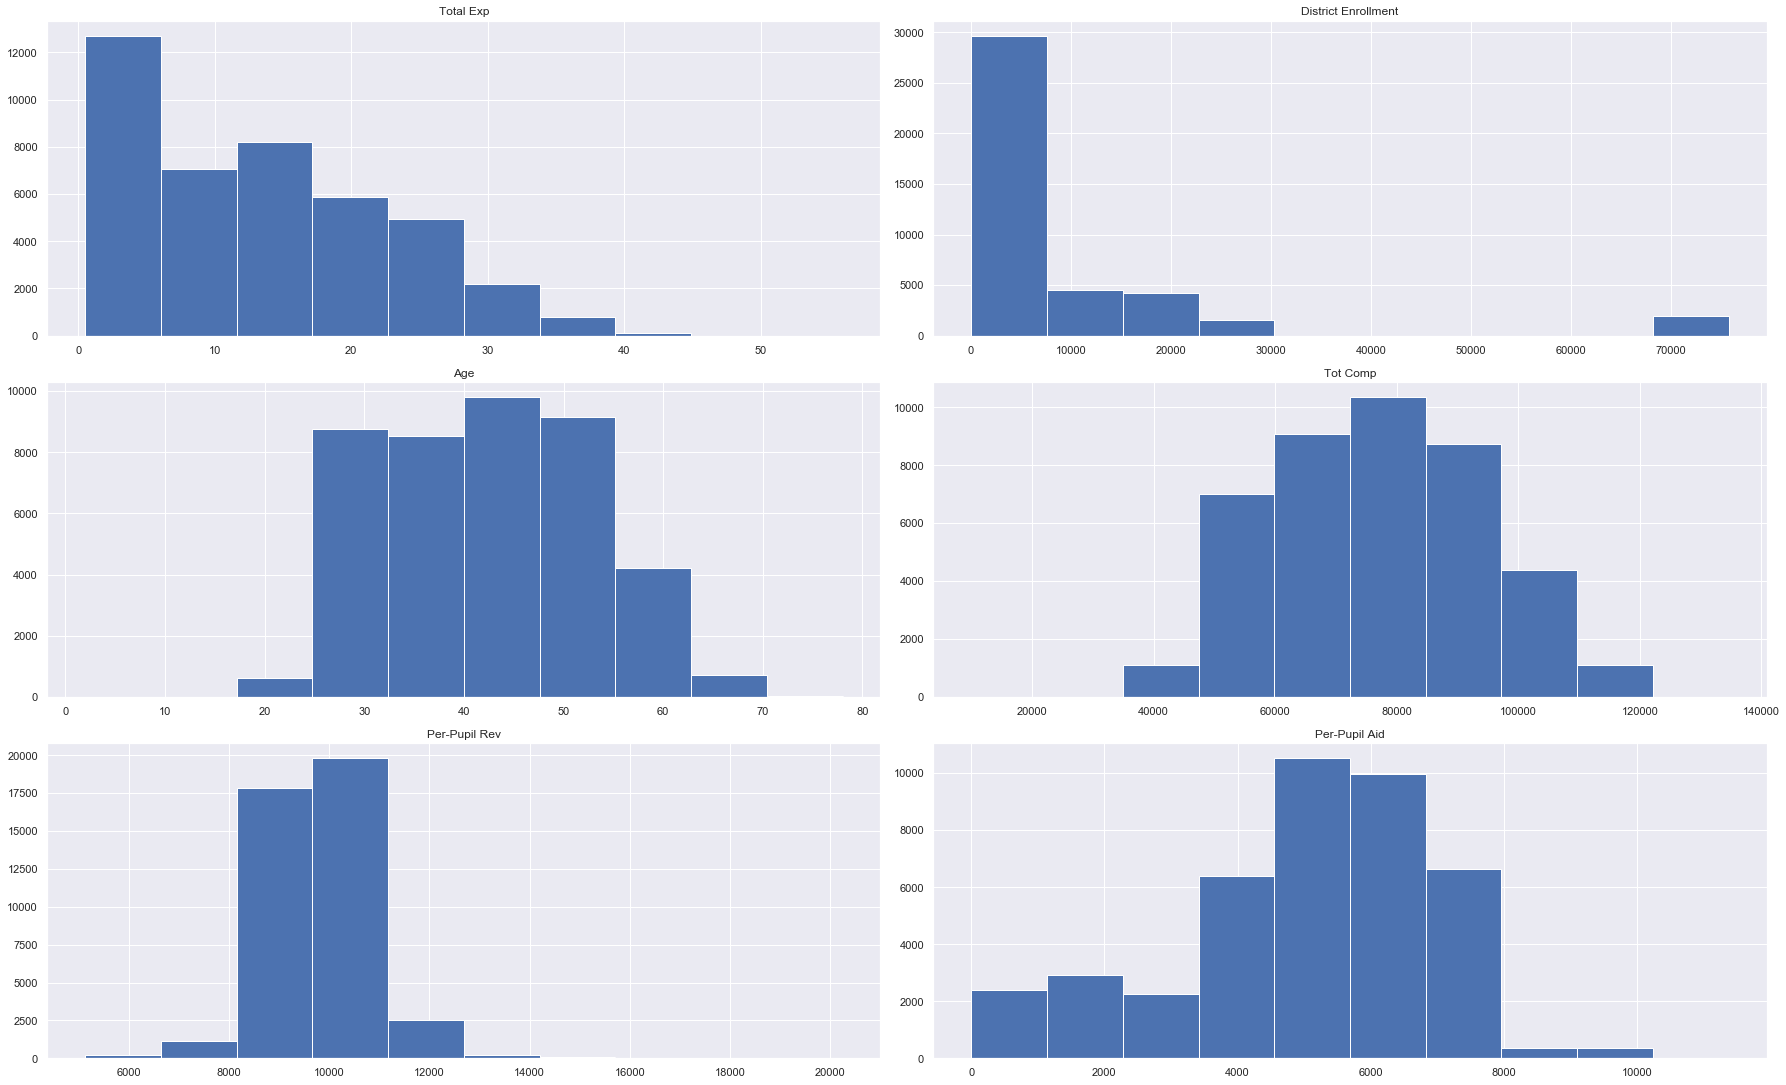

In [88]:
# Distributions of continuous data.

num_teachers = teachers[numeric_columns]

fig = plt.figure(figsize=(25,25))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(len(numeric_columns)):
    plt.subplot(5, 2, i+1)
    plt.hist(num_teachers.iloc[:,i])
    plt.title(numeric_columns[i])

plt.tight_layout()

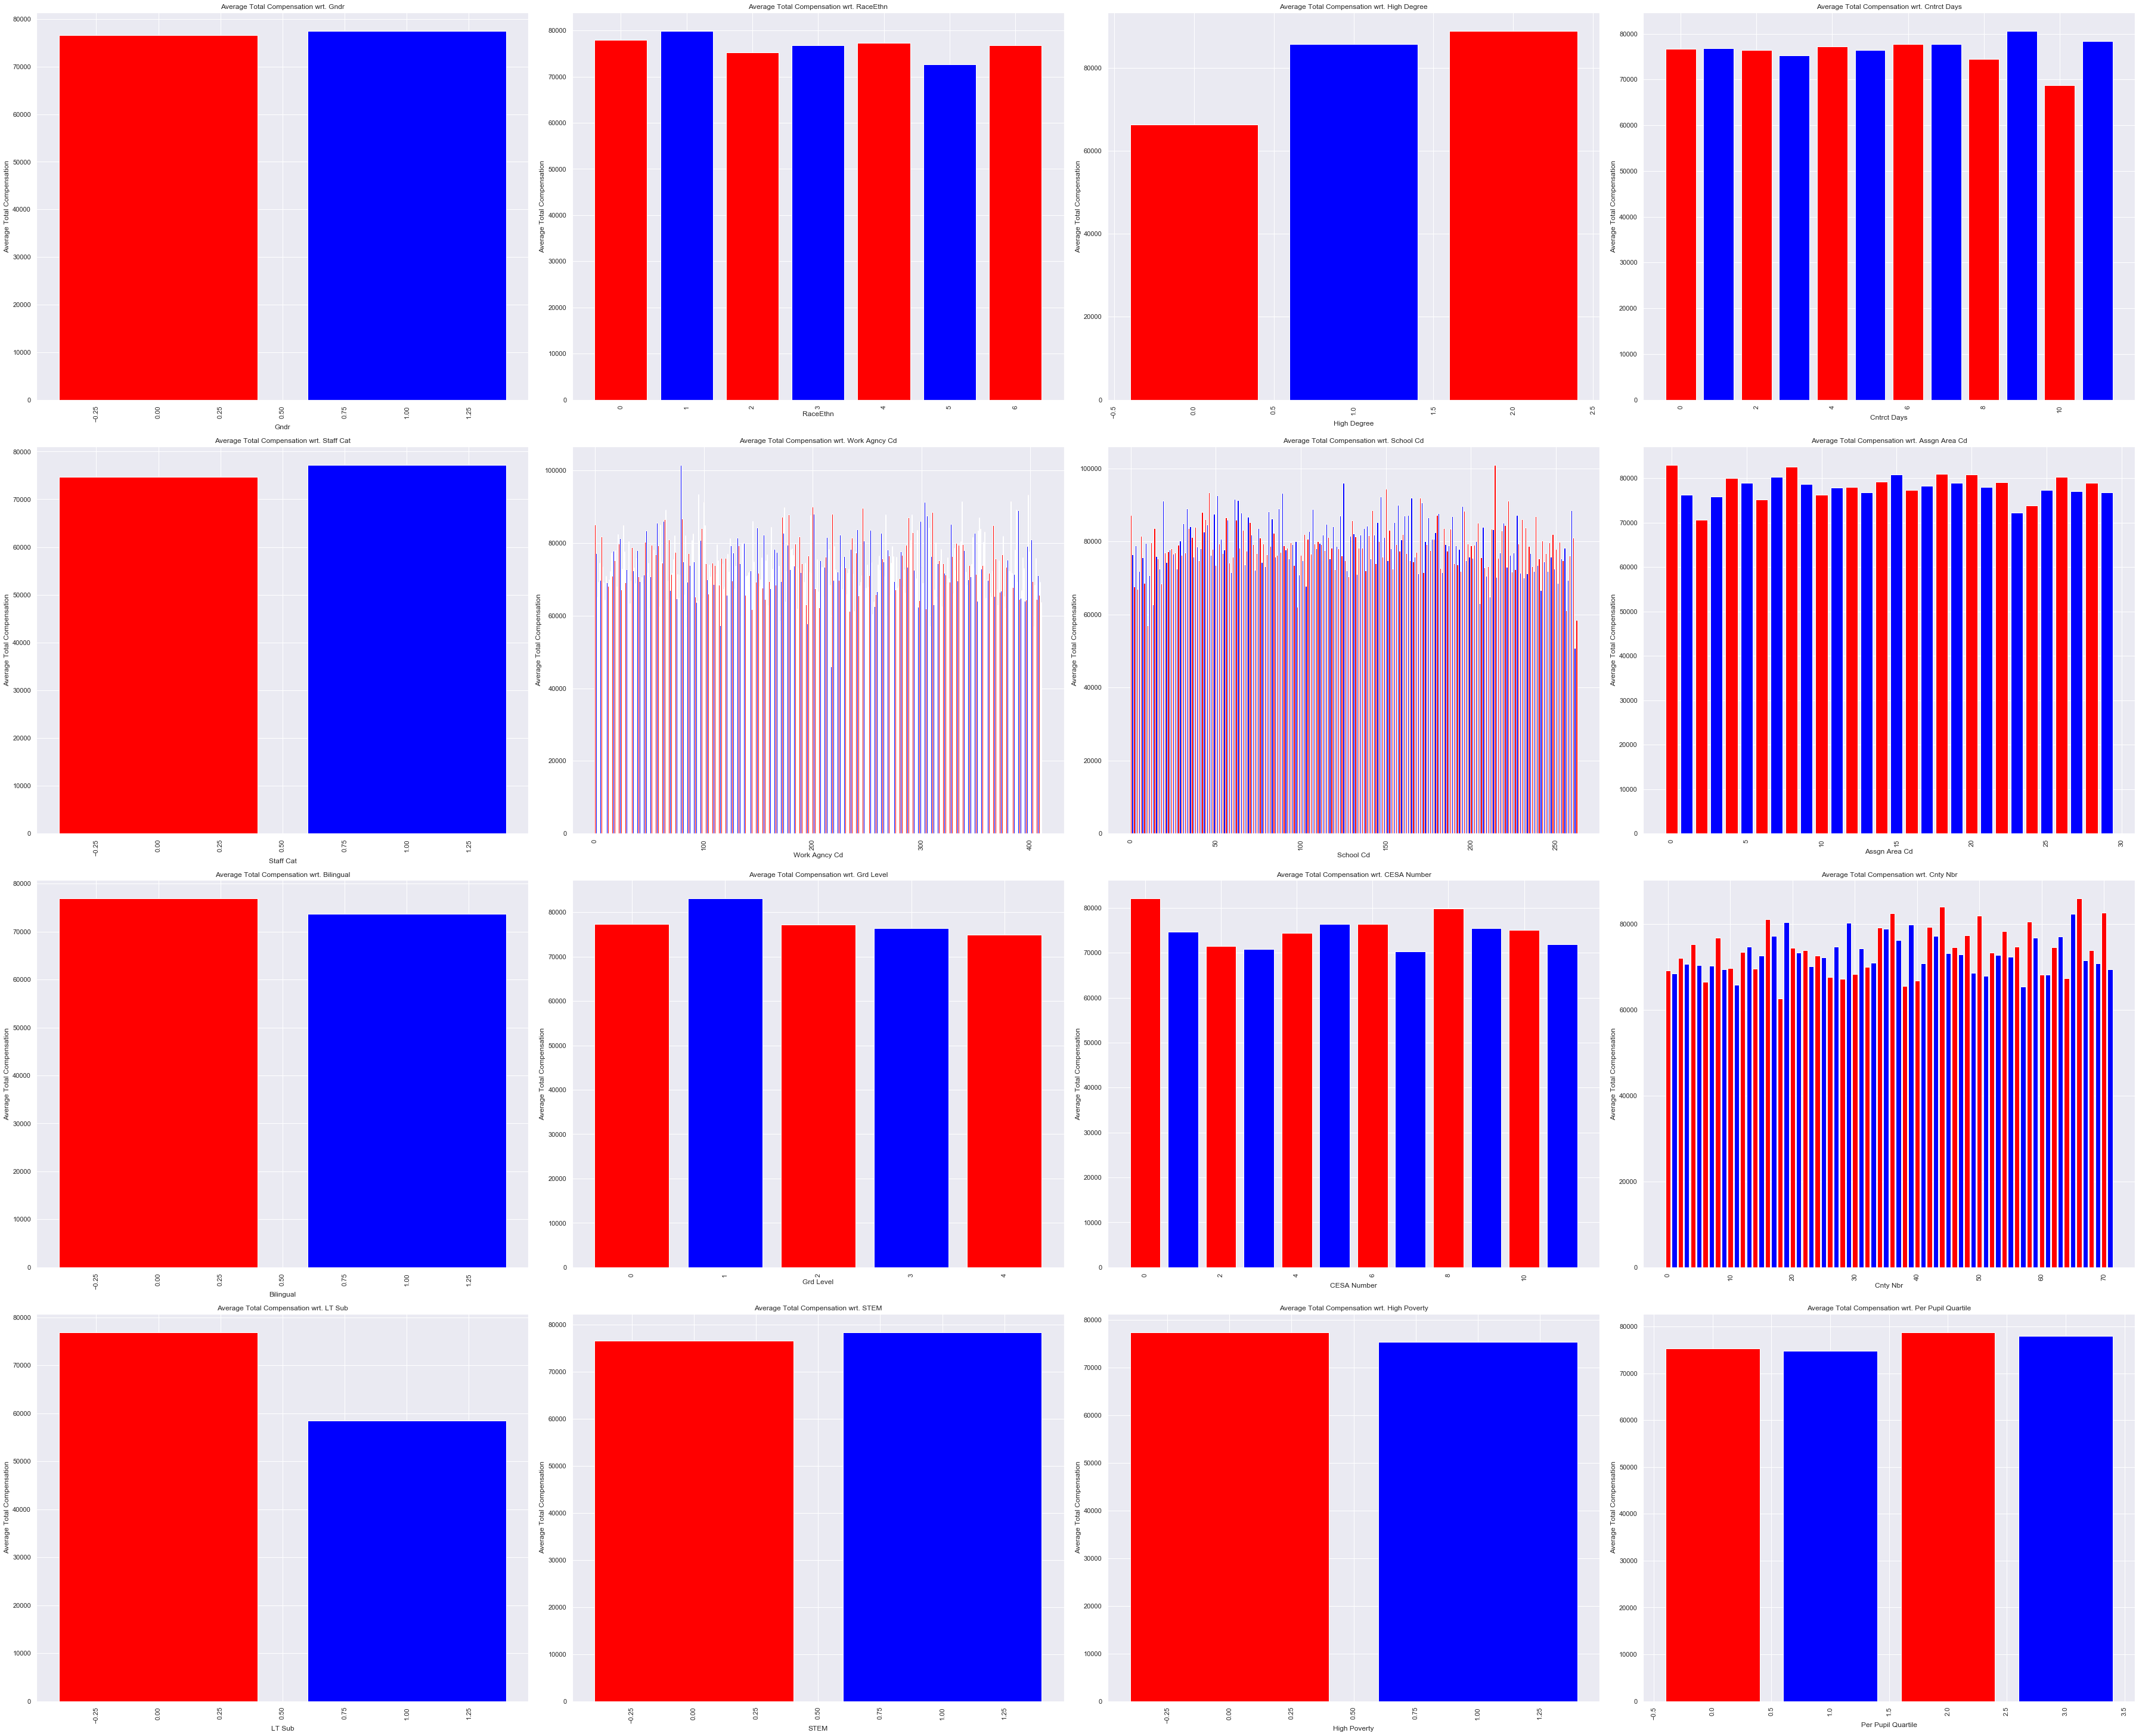

In [91]:
# Categorical variable variance with respect to Total Compensation.

plt.figure(figsize=(50,50))

for index, column in enumerate(non_numeric_columns):
    plt.subplot(5,4,index+1)
    plt.bar(teachers.groupby(column)["Tot Comp"].mean().index, teachers.groupby(column)["Tot Comp"].mean(),
           color=("red","blue"))
    plt.title("Average Total Compensation wrt. {}".format(column))
    plt.ylabel("Average Total Compensation")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

In order to find the most appropriate model I'm going to take this project down two paths, one using label encoded variables to be used with Random Forest and Gradient Boosting models and another path using dummy variables for use in Linear Regression and KNN models.

### Label Encoded Variables

In [45]:
def label_encode(data, cols):
    for col in cols:
        le = LabelEncoder()
        le.fit(data[col])
        data[col] = le.transform(data[col])
    return data

In [46]:
teachers_encoded = label_encode(teachers, non_numeric_columns)
teachers_encoded.head()

,Gndr,RaceEthn,High Degree,Cntrct Days,Total Exp,Staff Cat,Work Agncy Cd,School Cd,Assgn Area Cd,Bilingual,Grd Level,CESA Number,Cnty Nbr,LT Sub,District Enrollment,STEM,Age,Tot Comp,High Poverty,Per-Pupil Rev,Per-Pupil Aid,Per Pupil Quartile
0,0,6,0,2,11.0,1,395,7,1,0,3,9,9,0,713.0,0,61,66489,1,9421.197756,7485.29453,1
5,0,6,0,2,1.0,1,395,7,1,0,3,9,9,0,713.0,0,41,61829,1,9421.197756,7485.29453,1
6,0,6,0,2,16.0,1,395,7,1,0,3,9,9,0,713.0,0,50,64189,1,9421.197756,7485.29453,1
10,0,6,1,2,20.0,1,395,7,1,0,3,9,9,0,713.0,0,51,70806,1,9421.197756,7485.29453,1
11,0,6,0,2,7.0,1,395,7,1,0,3,9,9,0,713.0,0,35,71418,1,9421.197756,7485.29453,1


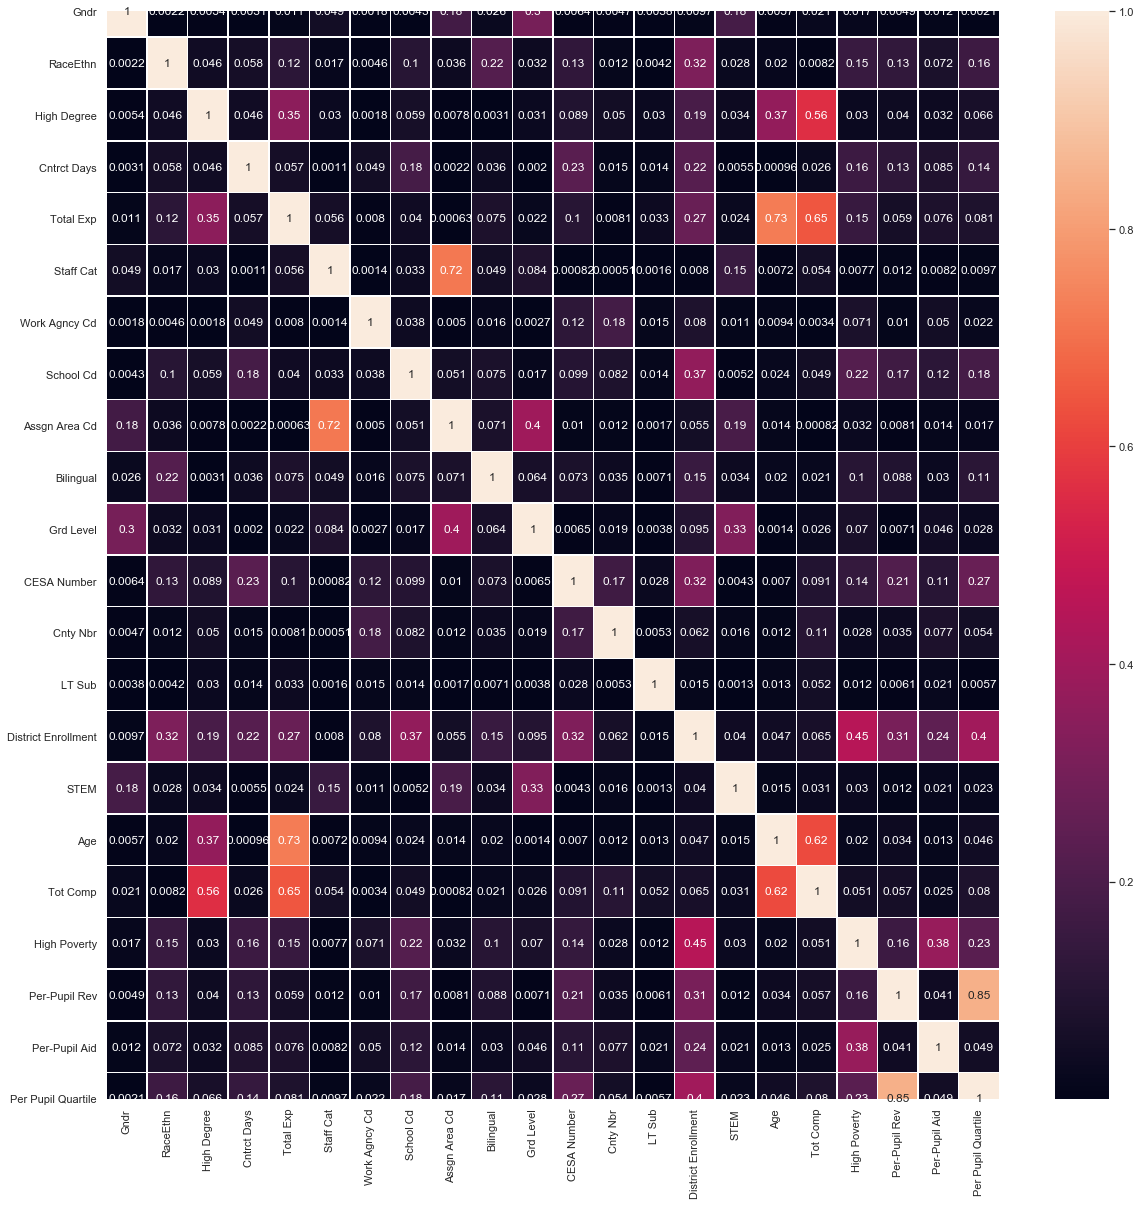

In [47]:
# Create a correlation matrix of all of the features in the label encoded set. 
enc_features = teachers_encoded.drop(labels='Tot Comp', axis=1)
enc_target = teachers_encoded['Tot Comp']
enc_features_corrmat = teachers_encoded.corr().abs()

sns.set()
f, ax = plt.subplots(figsize=(20,20))
sns.heatmap(enc_features_corrmat, annot=True, linewidths=.5, ax=ax)
plt.show()

In [48]:
# Drop correlated features:

# Select upper triangle of correlation matrix
upper = enc_features_corrmat.where(np.triu(np.ones(enc_features_corrmat.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

# Drop features
enc_features = enc_features.drop(enc_features[to_drop], axis=1)

In [49]:
print(to_drop)

['Per Pupil Quartile']


In [50]:
print(enc_features.columns)

Index(['Gndr', 'RaceEthn', 'High Degree', 'Cntrct Days', 'Total Exp',
       'Staff Cat', 'Work Agncy Cd', 'School Cd', 'Assgn Area Cd', 'Bilingual',
       'Grd Level', 'CESA Number', 'Cnty Nbr', 'LT Sub', 'District Enrollment',
       'STEM', 'Age', 'High Poverty', 'Per-Pupil Rev', 'Per-Pupil Aid'],
      dtype='object')


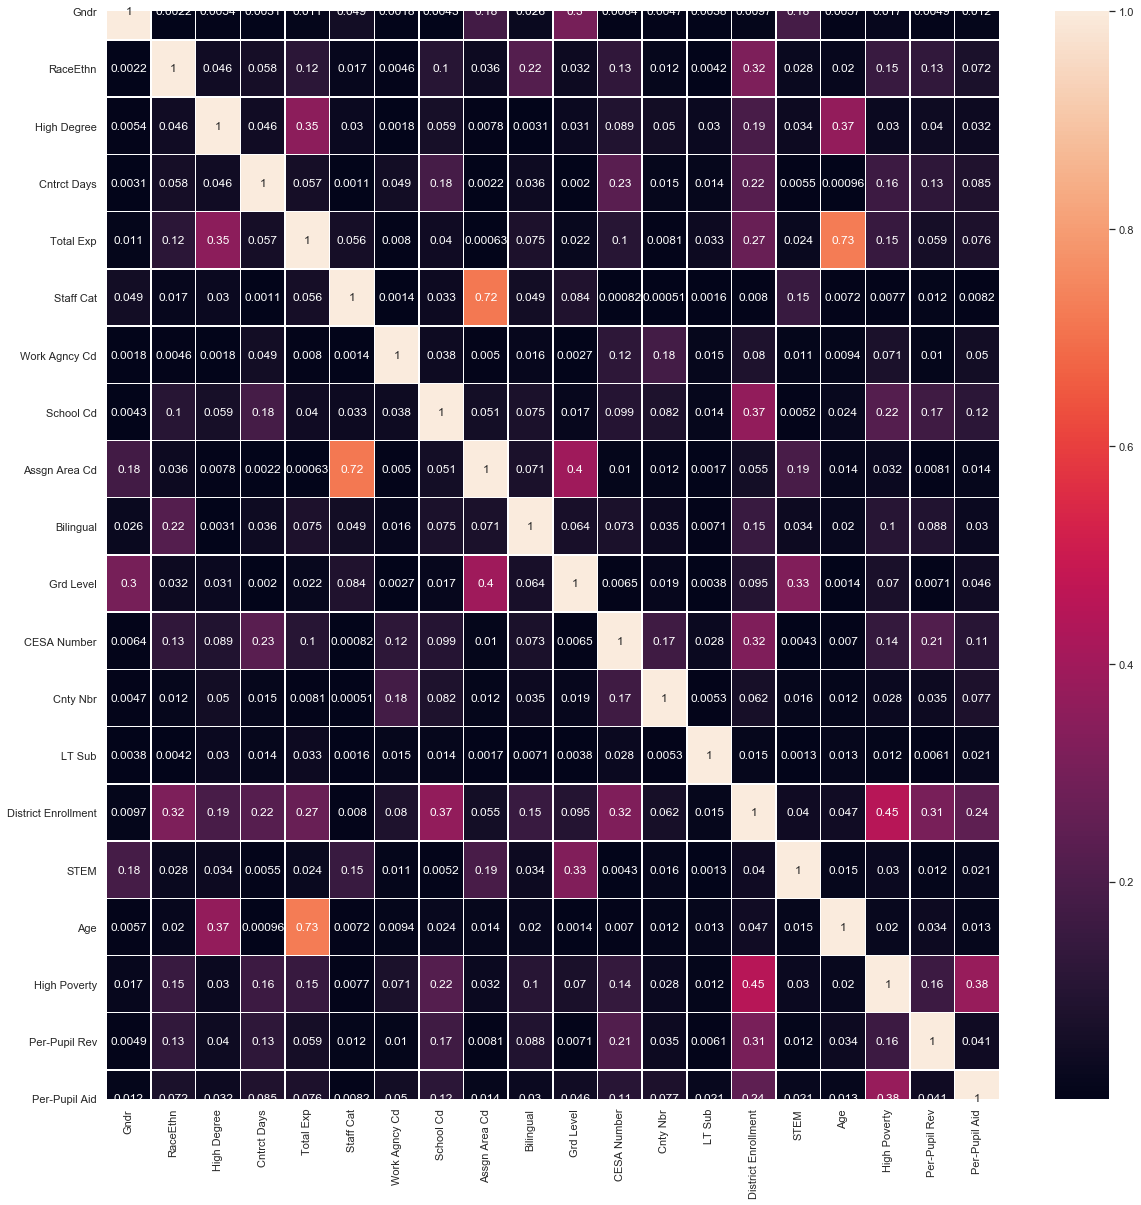

In [51]:
enc_features_corrmat = enc_features.corr().abs()

sns.set()
f, ax = plt.subplots(figsize=(20,20))
sns.heatmap(enc_features_corrmat, annot=True, linewidths=.5, ax=ax)
plt.show()

In [52]:
Xe = enc_features
ye = enc_target

rf = RandomForestRegressor(random_state=13)

# Create recursive feature eliminator
rfecv = RFECV(estimator=rf, step=1, cv=5, )

# Fit recursive feature eliminator 
rfecv.fit(Xe, ye)

# Number of best features
print(rfecv.n_features_)

# The best features
print(Xe.columns[rfecv.support_])

# Reduce X_rfe to only the best features to be used in modeling. 
Xe_rfe = Xe[Xe.columns[rfecv.support_]]


11
Index(['High Degree', 'Total Exp', 'Work Agncy Cd', 'School Cd',
       'Assgn Area Cd', 'CESA Number', 'Cnty Nbr', 'District Enrollment',
       'Age', 'Per-Pupil Rev', 'Per-Pupil Aid'],
      dtype='object')


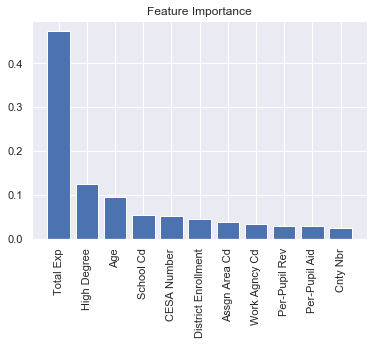

In [53]:
# Create decision tree regressor object
rf = RandomForestRegressor(n_jobs=-1)

# Train model
model = rf.fit(Xe_rfe, ye)

# Calculate feature importances
importances = model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [Xe_rfe.columns[i] for i in indices]

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(Xe_rfe.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(Xe_rfe.shape[1]), names, rotation=90)

# Show plot
plt.show()

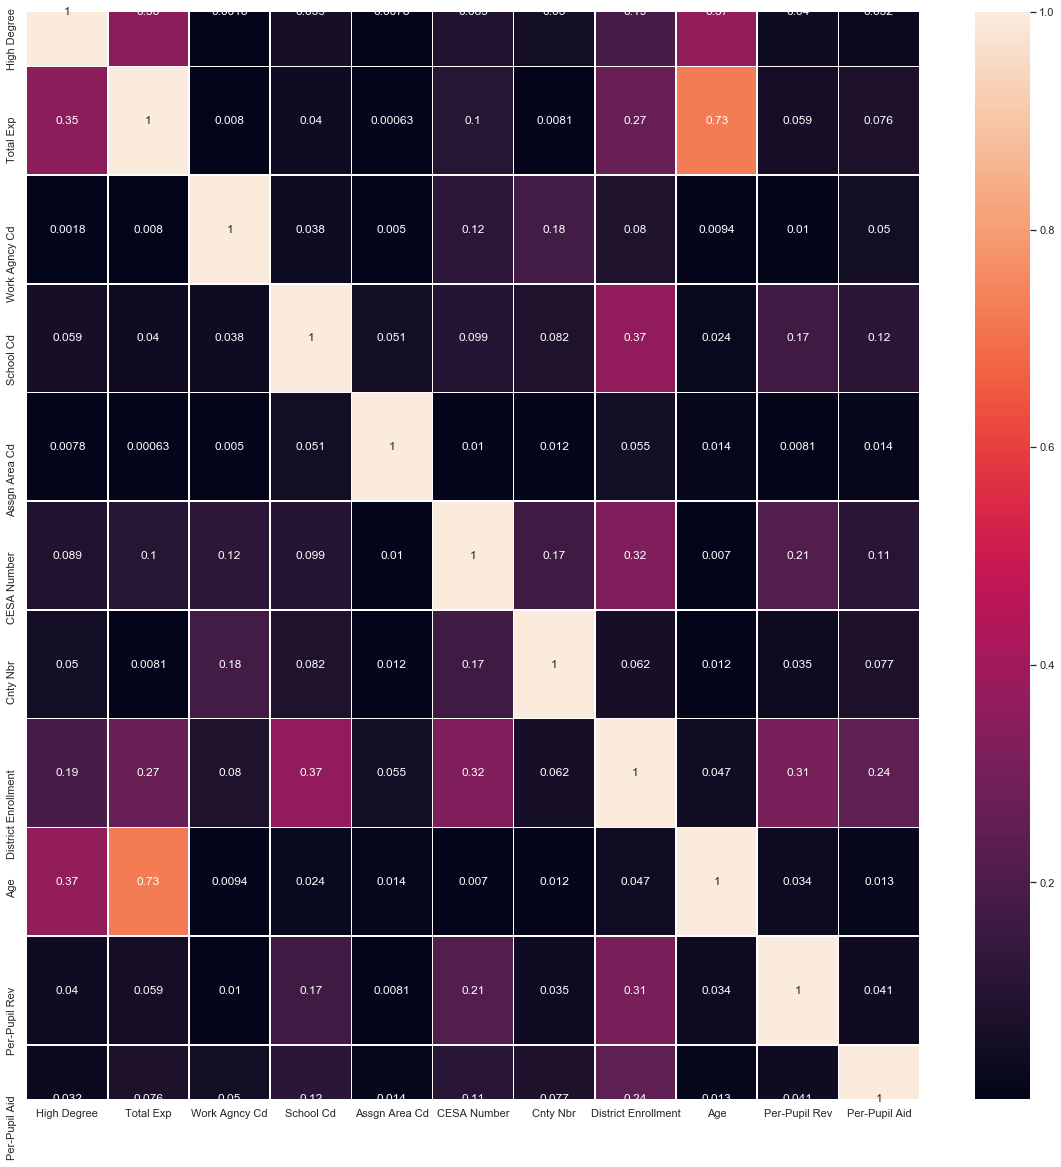

In [54]:
corrmat_X_rfe = Xe_rfe.corr().abs()

sns.set()
f, ax = plt.subplots(figsize=(20,20))
sns.heatmap(corrmat_X_rfe, annot=True, linewidths=.5, ax=ax)
plt.show()

### Base Modeling w/ Encoded Variables (Random Forest and Gradient Boosting)

R-squared of the model in training set is: 0.9449727273993823


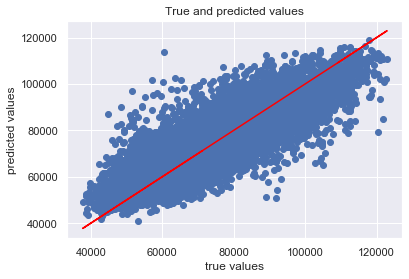

-----Test set statistics-----
R-squared of the model on the test set is: 0.7034216363613076


In [55]:
Xe_train, Xe_test, ye_train, ye_test = train_test_split(Xe_rfe, ye, test_size = 0.2, random_state=13)

rf = RandomForestRegressor(random_state=13)
rf.fit(Xe_train, ye_train)

ye_preds_train = rf.predict(Xe_train)
ye_preds_test = rf.predict(Xe_test)

print("R-squared of the model in training set is: {}".format(rf.score(Xe_train, ye_train)))

plt.scatter(ye_test, ye_preds_test)
plt.plot(ye_test, ye_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("True and predicted values")
plt.show()

print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(rf.score(Xe_test, ye_test)))

R-squared of the model in training set is: 0.7131503423398041


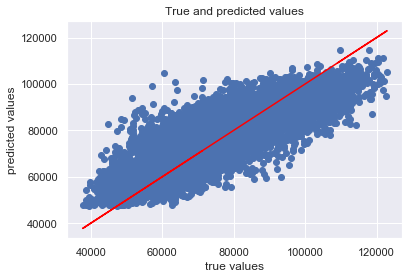

-----Test set statistics-----
R-squared of the model on the test set is: 0.7124374788070538


In [56]:
gb = GradientBoostingRegressor(random_state=13)
gb.fit(Xe_train, ye_train)

ye_preds_train = gb.predict(Xe_train)
ye_preds_test = gb.predict(Xe_test)

print("R-squared of the model in training set is: {}".format(gb.score(Xe_train, ye_train)))

plt.scatter(ye_test, ye_preds_test)
plt.plot(ye_test, ye_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("True and predicted values")
plt.show()

print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(gb.score(Xe_test, ye_test)))

### Using Dummy Variables

In [57]:
# One of the issues facing my project is the sheer number of unique values associated with some of my categorical
# features as shown below. 

for col in non_numeric_columns:
    print("Number of entries in " + col + ": " + str(teachers[col].nunique()))

Number of entries in Gndr: 2
Number of entries in RaceEthn: 7
Number of entries in High Degree: 3
Number of entries in Cntrct Days: 12
Number of entries in Staff Cat: 2
Number of entries in Work Agncy Cd: 411
Number of entries in School Cd: 263
Number of entries in Assgn Area Cd: 30
Number of entries in Bilingual: 2
Number of entries in Grd Level: 5
Number of entries in CESA Number: 12
Number of entries in Cnty Nbr: 72
Number of entries in LT Sub: 2
Number of entries in STEM: 2
Number of entries in High Poverty: 2
Number of entries in Per Pupil Quartile: 4


In [58]:
teachers_dummies = pd.get_dummies(teachers, columns=non_numeric_columns, drop_first=True)

In [59]:
# After getting dummies, I now have 821 columns in my dataset.

teachers_dummies.shape

(41796, 821)

In [60]:
# Create a correlation matrix of all of the features in the dummies version of teachers. 
dum_features = teachers_dummies.drop(labels='Tot Comp', axis=1)
dum_target = teachers_dummies['Tot Comp']
dum_features_corrmat = dum_features.corr().abs()

# Drop correlated features:

# Select upper triangle of correlation matrix
upper = dum_features_corrmat.where(np.triu(np.ones(dum_features_corrmat.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

# Drop features
dum_features = dum_features.drop(dum_features[to_drop], axis=1)

In [61]:
# After dropping everything that's correlated above 0.8 I'm still left with 802 columns.

dum_features.shape

(41796, 802)

### Modeling w/ Linear Regression & KNN

In [62]:
# Due to the size of my dataset, RFECV takes a very long time to run. Instead I've chosen to backwards elimate
# features that have a large p-value.

yd = dum_target 
Xd = dum_features
Xd = sm.add_constant(Xd)

Xd_train, Xd_test, yd_train, yd_test = train_test_split(Xd, yd, test_size = 0.2, random_state=13)

results = sm.OLS(yd_train, Xd_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Tot Comp   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     107.6
Date:                Wed, 11 Mar 2020   Prob (F-statistic):               0.00
Time:                        11:42:40   Log-Likelihood:            -3.5309e+05
No. Observations:               33436   AIC:                         7.076e+05
Df Residuals:                   32707   BIC:                         7.138e+05
Df Model:                         728                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2.901e+04   3457.492      8.390      0.000    2.22e+04    3.58e+04
Total Exp              804.0445      9.738     82.569      0.000     784.958     823.131
District Enrollment      0.0247      0.018      1.374      0.170      -0.011       0.060
Age                    306.5202      8.055     38.053      0.000     290.732     322.308
Per-Pupil Rev            1.9211      0.210      9.160      0.000       1.510       2.332
Per-Pupil Aid            0.3551      0.080      4.428      0.000       0.198       0.512
Gndr_1                  12.5207    141.197      0.089      0.929    -264.230     289.272
RaceEthn_1            -529.6706    814.874     -0.650      0.516   -2126.853    1067.512
RaceEthn_2           -2313.3394    800.147     -2.891      0.004   -3881.657    -745.021
RaceEthn_3            -117.7644   1243.381     -0.095      0.925   -2554.836    2319.307
RaceEthn_4           -3879.8951   2541.904     -1.526      0.127   -8862.119    1102.329
RaceEthn_5           -2781.0808   1208.211     -2.302      0.021   -5149.218    -412.944
RaceEthn_6           -1196.5266    657.359     -1.820      0.069   -2484.975      91.922
High Degree_1         9926.1586    123.660     80.270      0.000    9683.781    1.02e+04
High Degree_2         1.186e+04   1166.203     10.169      0.000    9573.680    1.41e+04
Cntrct Days_1         2763.0980   2749.887      1.005      0.315   -2626.780    8152.976
Cntrct Days_2        -1338.2416   2340.250     -0.572      0.567   -5925.218    3248.735
Cntrct Days_3         4028.5701   2518.826      1.599      0.110    -908.421    8965.562
Cntrct Days_4         9230.0972   2694.980      3.425      0.001    3947.838    1.45e+04
Cntrct Days_5         3168.6881   2511.872      1.261      0.207   -1754.672    8092.048
Cntrct Days_6         5852.6570   2495.750      2.345      0.019     960.896    1.07e+04
Cntrct Days_7         3264.3964   2648.078      1.233      0.218   -1925.933    8454.725
Cntrct Days_8         5946.2037   2902.299      2.049      0.040     257.593    1.16e+04
Cntrct Days_9          887.5099   7300.326      0.122      0.903   -1.34e+04    1.52e+04
Cntrct Days_10        1268.5133   2807.541      0.452      0.651   -4234.370    6771.397
Cntrct Days_11        7818.6812   3256.323      2.401      0.016    1436.169    1.42e+04
Staff Cat_1           5106.0170   2455.184      2.080      0.038     293.766    9918.268
Work Agncy Cd_1      -1493.4752   1771.575     -0.843      0.399   -4965.827    1978.876
Work Agncy Cd_2        209.3701   2607.793      0.080      0.936   -4901.999    5320.739
Work Agncy Cd_3       8539.2296   1836.409      4.650      0.000    4939.800    1.21e+04
Work Agncy Cd_4        522.3188   2100.915      0.249      0.804   -3595.552    4640.189
Work Agncy Cd_5      -1463.8240   1605.057     -0.912    

In [63]:
yd = dum_target 
Xd = dum_features
Xd = sm.add_constant(Xd)

Xd_train, Xd_test, yd_train, yd_test = train_test_split(Xd, yd, test_size = 0.2, random_state=13)

results = sm.OLS(yd_train, Xd_train).fit()

max_value = max(results.pvalues)
drop_features = results.params.index[results.pvalues == max_value]
keep_features = results.params.index.drop(drop_features)
keep_features = keep_features.drop('const')

while len(drop_features) > 0:
    yd = dum_target
    Xd = dum_features[keep_features]
    Xd = sm.add_constant(Xd)
    
    Xd_train, Xd_test, yd_train, yd_test = train_test_split(Xd, yd, test_size = 0.2, random_state=13)

    results = sm.OLS(yd_train, Xd_train).fit()
    
    max_value = max(results.pvalues)
    
    if max_value > 0.05:
        print("Dropping {} with a p-value of: {}".format(results.params.index[results.pvalues == max_value], max_value))
        drop_features = results.params.index[results.pvalues == max_value]
        keep_features = results.params.index.drop(drop_features)
        print("Length of remaining features is: {}".format(len(keep_features)))
        keep_features = keep_features.drop('const')
    else:
        drop_features = []
        print('All Done! The final number of features is: {}'.format(len(keep_features)))


Dropping Index(['Work Agncy Cd_346'], dtype='object') with a p-value of: 0.9942619332631639
Length of remaining features is: 801
Dropping Index(['Work Agncy Cd_282'], dtype='object') with a p-value of: 0.9950029174820351
Length of remaining features is: 800
Dropping Index(['Work Agncy Cd_355'], dtype='object') with a p-value of: 0.9753129873307205
Length of remaining features is: 799
Dropping Index(['CESA Number_10'], dtype='object') with a p-value of: 0.9711953977765022
Length of remaining features is: 798
Dropping Index(['Work Agncy Cd_409'], dtype='object') with a p-value of: 0.9744575042693151
Length of remaining features is: 797
Dropping Index(['Work Agncy Cd_281'], dtype='object') with a p-value of: 0.9713769221712185
Length of remaining features is: 796
Dropping Index(['Work Agncy Cd_72'], dtype='object') with a p-value of: 0.9700857532525413
Length of remaining features is: 795
Dropping Index(['Work Agncy Cd_266'], dtype='object') with a p-value of: 0.9683445252160975
Length of

Dropping Index(['School Cd_49'], dtype='object') with a p-value of: 0.8553264485673036
Length of remaining features is: 736
Dropping Index(['Work Agncy Cd_253'], dtype='object') with a p-value of: 0.854787092036897
Length of remaining features is: 735
Dropping Index(['CESA Number_4'], dtype='object') with a p-value of: 0.8881346351085141
Length of remaining features is: 734
Dropping Index(['Work Agncy Cd_319'], dtype='object') with a p-value of: 0.8595139277438106
Length of remaining features is: 733
Dropping Index(['Work Agncy Cd_105'], dtype='object') with a p-value of: 0.8575336185536104
Length of remaining features is: 732
Dropping Index(['Work Agncy Cd_118'], dtype='object') with a p-value of: 0.8572400672428006
Length of remaining features is: 731
Dropping Index(['School Cd_107'], dtype='object') with a p-value of: 0.8470556789971535
Length of remaining features is: 730
Dropping Index(['School Cd_44'], dtype='object') with a p-value of: 0.8614541503339912
Length of remaining feat

Dropping Index(['Cnty Nbr_47'], dtype='object') with a p-value of: 0.6577090871008345
Length of remaining features is: 671
Dropping Index(['Cnty Nbr_67'], dtype='object') with a p-value of: 0.6887320841316467
Length of remaining features is: 670
Dropping Index(['Work Agncy Cd_209'], dtype='object') with a p-value of: 0.6866809189579681
Length of remaining features is: 669
Dropping Index(['Work Agncy Cd_280'], dtype='object') with a p-value of: 0.689105967406523
Length of remaining features is: 668
Dropping Index(['Work Agncy Cd_255'], dtype='object') with a p-value of: 0.626102619339395
Length of remaining features is: 667
Dropping Index(['Work Agncy Cd_32'], dtype='object') with a p-value of: 0.6256660195252658
Length of remaining features is: 666
Dropping Index(['Work Agncy Cd_52'], dtype='object') with a p-value of: 0.6418211654636717
Length of remaining features is: 665
Dropping Index(['Cnty Nbr_2'], dtype='object') with a p-value of: 0.6407779541286347
Length of remaining features

Dropping Index(['Work Agncy Cd_81'], dtype='object') with a p-value of: 0.39996462588543036
Length of remaining features is: 606
Dropping Index(['Work Agncy Cd_383'], dtype='object') with a p-value of: 0.39068355914256647
Length of remaining features is: 605
Dropping Index(['Work Agncy Cd_83'], dtype='object') with a p-value of: 0.38871208125959245
Length of remaining features is: 604
Dropping Index(['Work Agncy Cd_358'], dtype='object') with a p-value of: 0.39942366699776644
Length of remaining features is: 603
Dropping Index(['Work Agncy Cd_321'], dtype='object') with a p-value of: 0.5983339842856832
Length of remaining features is: 602
Dropping Index(['School Cd_137'], dtype='object') with a p-value of: 0.3877829680912859
Length of remaining features is: 601
Dropping Index(['School Cd_53'], dtype='object') with a p-value of: 0.3882748335716618
Length of remaining features is: 600
Dropping Index(['School Cd_90'], dtype='object') with a p-value of: 0.41098126607214136
Length of remain

Dropping Index(['Work Agncy Cd_21'], dtype='object') with a p-value of: 0.3362140284544045
Length of remaining features is: 541
Dropping Index(['Work Agncy Cd_19'], dtype='object') with a p-value of: 0.3666122539176975
Length of remaining features is: 540
Dropping Index(['Work Agncy Cd_141'], dtype='object') with a p-value of: 0.5590436322612304
Length of remaining features is: 539
Dropping Index(['School Cd_19'], dtype='object') with a p-value of: 0.3356004364822399
Length of remaining features is: 538
Dropping Index(['School Cd_121'], dtype='object') with a p-value of: 0.3400111171548771
Length of remaining features is: 537
Dropping Index(['School Cd_213'], dtype='object') with a p-value of: 0.37404802557858396
Length of remaining features is: 536
Dropping Index(['School Cd_250'], dtype='object') with a p-value of: 0.35566378638442053
Length of remaining features is: 535
Dropping Index(['School Cd_243'], dtype='object') with a p-value of: 0.3604222668587529
Length of remaining featur

Dropping Index(['School Cd_112'], dtype='object') with a p-value of: 0.29384342697200294
Length of remaining features is: 475
Dropping Index(['School Cd_186'], dtype='object') with a p-value of: 0.269595231478621
Length of remaining features is: 474
Dropping Index(['Work Agncy Cd_4'], dtype='object') with a p-value of: 0.26739207639143425
Length of remaining features is: 473
Dropping Index(['Work Agncy Cd_347'], dtype='object') with a p-value of: 0.2679716949582661
Length of remaining features is: 472
Dropping Index(['School Cd_87'], dtype='object') with a p-value of: 0.2628339183380917
Length of remaining features is: 471
Dropping Index(['School Cd_234'], dtype='object') with a p-value of: 0.25934048514642294
Length of remaining features is: 470
Dropping Index(['School Cd_239'], dtype='object') with a p-value of: 0.2712540855093881
Length of remaining features is: 469
Dropping Index(['School Cd_15'], dtype='object') with a p-value of: 0.2557504523688491
Length of remaining features is

Dropping Index(['Cnty Nbr_31'], dtype='object') with a p-value of: 0.30648115102314744
Length of remaining features is: 410
Dropping Index(['School Cd_92'], dtype='object') with a p-value of: 0.1999537370278275
Length of remaining features is: 409
Dropping Index(['School Cd_43'], dtype='object') with a p-value of: 0.1988256897058141
Length of remaining features is: 408
Dropping Index(['School Cd_158'], dtype='object') with a p-value of: 0.19712488364866151
Length of remaining features is: 407
Dropping Index(['School Cd_108'], dtype='object') with a p-value of: 0.1977432649332298
Length of remaining features is: 406
Dropping Index(['Work Agncy Cd_348'], dtype='object') with a p-value of: 0.1877729528667915
Length of remaining features is: 405
Dropping Index(['Cnty Nbr_61'], dtype='object') with a p-value of: 0.1894377926969441
Length of remaining features is: 404
Dropping Index(['Work Agncy Cd_301'], dtype='object') with a p-value of: 0.18802416052561627
Length of remaining features is:

Dropping Index(['Work Agncy Cd_341'], dtype='object') with a p-value of: 0.09049694116594496
Length of remaining features is: 345
Dropping Index(['Work Agncy Cd_40'], dtype='object') with a p-value of: 0.08726334836800817
Length of remaining features is: 344
Dropping Index(['Cnty Nbr_68'], dtype='object') with a p-value of: 0.08840644930007976
Length of remaining features is: 343
Dropping Index(['Work Agncy Cd_380'], dtype='object') with a p-value of: 0.38680049154390694
Length of remaining features is: 342
Dropping Index(['Work Agncy Cd_101'], dtype='object') with a p-value of: 0.08346825035613531
Length of remaining features is: 341
Dropping Index(['Work Agncy Cd_360'], dtype='object') with a p-value of: 0.0820572429803783
Length of remaining features is: 340
Dropping Index(['School Cd_153'], dtype='object') with a p-value of: 0.07862952765424434
Length of remaining features is: 339
Dropping Index(['School Cd_152'], dtype='object') with a p-value of: 0.07709391405642993
Length of rem

In [64]:
# After eliminating features one at a time, I'm left with 310 features that are significant.

len(keep_features)

310

In [65]:
# Unfortunately, this didn't yield an improvement in the linear model. 

yd = dum_target 
Xd = dum_features[keep_features]
Xd = sm.add_constant(Xd)

Xd_train, Xd_test, yd_train, yd_test = train_test_split(Xd, yd, test_size = 0.2, random_state=13)

results = sm.OLS(yd_train, Xd_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Tot Comp   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     252.7
Date:                Wed, 11 Mar 2020   Prob (F-statistic):               0.00
Time:                        12:19:52   Log-Likelihood:            -3.5331e+05
No. Observations:               33436   AIC:                         7.072e+05
Df Residuals:                   33127   BIC:                         7.098e+05
Df Model:                         308                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  3.33e+04   1118.222     29.776      0.000    3.11e+04    3.55e+04
Total Exp              803.6688      9.421     85.305      0.000     785.203     822.135
Age                    308.5528      7.894     39.087      0.000     293.080     324.025
Per-Pupil Rev            0.7910      0.092      8.635      0.000       0.611       0.971
Per-Pupil Aid            0.2721      0.061      4.458      0.000       0.152       0.392
RaceEthn_2           -1838.9521    540.239     -3.404      0.001   -2897.841    -780.064
RaceEthn_5           -2372.7769   1071.740     -2.214      0.027   -4473.426    -272.128
RaceEthn_6            -732.6307    363.302     -2.017      0.044   -1444.716     -20.545
High Degree_1         9965.2121    120.842     82.465      0.000    9728.358    1.02e+04
High Degree_2         1.204e+04   1157.082     10.401      0.000    9767.377    1.43e+04
Cntrct Days_1         2885.6069    471.959      6.114      0.000    1960.550    3810.664
Cntrct Days_3         4301.5930    410.941     10.468      0.000    3496.134    5107.052
Cntrct Days_4         8124.2282    404.743     20.073      0.000    7330.917    8917.539
Cntrct Days_5         2060.2668    340.173      6.057      0.000    1393.515    2727.019
Cntrct Days_6         5255.7462    394.954     13.307      0.000    4481.622    6029.870
Cntrct Days_7         3163.5583    414.644      7.630      0.000    2350.840    3976.276
Cntrct Days_8         5546.0041    843.401      6.576      0.000    3892.909    7199.100
Cntrct Days_11        8282.0199    483.231     17.139      0.000    7334.870    9229.170
Staff Cat_1           4701.0762    341.887     13.750      0.000    4030.966    5371.187
Work Agncy Cd_3       8398.9628   2413.885      3.479      0.001    3667.662    1.31e+04
Work Agncy Cd_5      -5131.7106   1431.711     -3.584      0.000   -7937.915   -2325.506
Work Agncy Cd_6       8540.9165    734.006     11.636      0.000    7102.239    9979.594
Work Agncy Cd_9      -1.323e+04   2388.654     -5.538      0.000   -1.79e+04   -8546.207
Work Agncy Cd_12     -1.127e+04   2255.775     -4.995      0.000   -1.57e+04   -6846.164
Work Agncy Cd_13     -9188.9872   1713.522     -5.363      0.000   -1.25e+04   -5830.422
Work Agncy Cd_15     -5799.3808   1587.955     -3.652      0.000   -8911.830   -2686.932
Work Agncy Cd_17      5077.5364   1270.331      3.997      0.000    2587.642    7567.430
Work Agncy Cd_18      6923.9477   3014.895      2.297      0.022    1014.647    1.28e+04
Work Agncy Cd_20      5097.8294   2004.827      2.543      0.011    1168.298    9027.361
Work Agncy Cd_22      5040.1026   1658.422      3.039      0.002    1789.537    8290.668
Work Agncy Cd_23      1.126e+04   1870.401      6.020      0.000    7593.297    1.49e+04
Work Agncy Cd_26     -7543.8726    987.565     -7.639    

Best alpha value is: 0.01
R-squared of the model in training set is: 0.7014168338558004


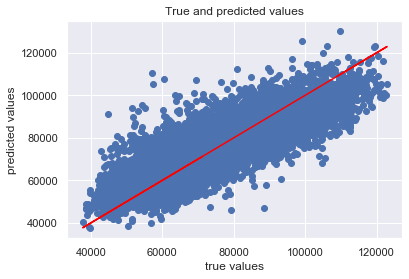

-----Test set statistics-----
R-squared of the model on the test set is: 0.6941665435594153
Mean absolute error of the prediction is: 7538.172754800993
Mean squared error of the prediction is: 91532093.98576918
Root mean squared error of the prediction is: 9567.240667285902
Mean absolute percentage error of the prediction is: 10.345298417073924
-----Linear Assumption Tests-----
Mean of the errors is: 51.86059148695339
Bartlett test statistic value is 7280.07 and p value is 0
Levene test statistic value is 8526.97 and p value is 0


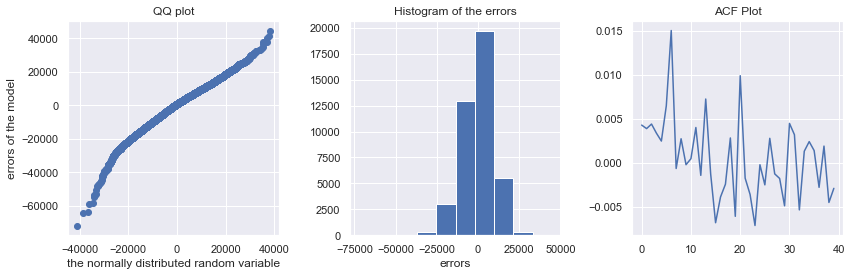

In [66]:
# Another method of reducing the number of features is to use Lasso, which I run here using the already filtered
# feature set, which performs similarly to the normal OLS regression on the filtered data set.

alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]
lasso_cv = LassoCV(alphas=alphas, cv=5)
lasso_cv.fit(Xd_train, yd_train)

print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(Xd_train, yd_train)))

yd_preds_train = lasso_cv.predict(Xd_train)
yd_preds_test = lasso_cv.predict(Xd_test)

plt.scatter(yd_test, yd_preds_test)
plt.plot(yd_test, yd_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("True and predicted values")
plt.show()

print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lasso_cv.score(Xd_test, yd_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(yd_test, yd_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(yd_test, yd_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(yd_test, yd_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((yd_test - yd_preds_test) / yd_test)) * 100))

predictions = lasso_cv.predict(Xd)
errors = yd - predictions

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("-----Linear Assumption Tests-----")
print("Mean of the errors is: {}".format(np.mean(errors)))
print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.scatter(np.sort(rand_nums), np.sort(errors))
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,3,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.subplot(1,3,3)
acf_data = acf(errors)
plt.plot(acf_data[1:])
plt.title("ACF Plot")

plt.tight_layout()
plt.show()

R-squared of the model in training set is: 0.7409703023028663


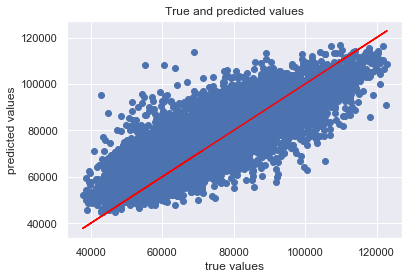

-----Test set statistics-----
R-squared of the model on the test set is: 0.6865847024945275


In [67]:
# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=10)
knn.fit(Xd_train, yd_train)

yd_preds_train = knn.predict(Xd_train)
yd_preds_test = knn.predict(Xd_test)

print("R-squared of the model in training set is: {}".format(knn.score(Xd_train, yd_train)))

plt.scatter(yd_test, yd_preds_test)
plt.plot(yd_test, yd_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("True and predicted values")
plt.show()

print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(knn.score(Xd_test, yd_test)))


# Optimizing Gradient Boosting Model

The best performing base model on the test set was Gradient Boosting, which I'll optimize using a combination of RandomSearch and GridSearch.

In [69]:
# Learning rate
learn_rate = [float(x) for x in np.linspace(start = .01, stop = 1, num = 11)]
    
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 11)]

# Minimum number of samples required to split a node
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 20, num = 11)]

# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 20, num = 11)]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']

# Create the random grid
random_grid = {'learning_rate' : learn_rate,
                'n_estimators': n_estimators,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'max_depth': max_depth,
                'max_features': max_features}

# Use the random grid to search for best hyperparameters
# First create the base model to tune

gb = GradientBoostingRegressor(random_state=13)

# Random search of parameters, using 3 fold cross validation

gb_random = RandomizedSearchCV(estimator = gb, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=50, random_state=13, n_jobs = -1)

# Fit the random search model
gb_random.fit(Xe_train, ye_train)

# Best paramaters
print(gb_random.best_params_)

# Store best random
best_random = gb_random.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 43.7min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed: 53.1min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed: 54.3min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 54.3min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 59.

In [70]:
gb_opt = GradientBoostingRegressor(random_state=13)

# Learning rate
learn_rate = [.01, .10]

# Number of trees in random forest
n_estimators = [300, 500, 700]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [2]

# Maximum number of levels in tree
max_depth = [None, 10]

# Number of features to consider at every split
max_features = ['log2']

parameter_candidates = {'learning_rate' : learn_rate,
                'n_estimators': n_estimators,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'max_depth': max_depth,
                'max_features': max_features}

gb_gs = GridSearchCV(estimator=gb_opt, param_grid=parameter_candidates, cv=3, n_jobs=-1, verbose=50)

gb_gs.fit(Xe_train, ye_train)

best_gs = gb_gs.best_estimator_

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 28.7min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed: 28.8min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed: 36.1min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 37.4min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 43.1min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 45.1min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed: 46.5min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed: 53.1min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 57.1min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 58

### Comparing Models

In [86]:
# Base Model

print("------------------------- Base Gradient Boosting Model -------------------------")
gb.fit(Xe_train, ye_train)
ye_preds_train = gb.predict(Xe_train)
ye_preds_test = gb.predict(Xe_test)

base_r2_train = gb.score(Xe_train, ye_train)
base_r2_test = gb.score(Xe_test, ye_test)
base_mse = mse(ye_test, ye_preds_test)
base_rmse = rmse(ye_test, ye_preds_test)
base_mae = mean_absolute_error(ye_test, ye_preds_test)

print("R-squared of the base model in training set is: {:0.4f}.".format(base_r2_train))
print("R-squared of the base model on the test set is: {:0.4f}.".format(base_r2_test))

print("Mean squared error of the base model on the test set is: {:0.4f}.".format(base_mse))
print("Root mean squared error of the base model's prediction is: {:0.4f}.".format(base_rmse))
print("Mean absolute error of the base model's prediction is: {:0.4f}.".format(base_mae))

# Best RandomSearch Model

print("------------------------- Best Random Search Model -------------------------")

best_random.fit(Xe_train, ye_train)
ye_preds_train = best_random.predict(Xe_train)
ye_preds_test = best_random.predict(Xe_test)

print("R-squared of the best random search model in training set is: {:0.4f}.".format(best_random.score(Xe_train, ye_train)))
print("R-squared of the best random search model on the test set is: {:0.4f}.".format(best_random.score(Xe_test, ye_test)))

print("Mean squared error of the best random search model on the test set is: {:0.4f}.".format(mse(ye_test, ye_preds_test)))
print("Root mean squared error of the best random search model's prediction is: {:0.4f}.".format(rmse(ye_test, ye_preds_test)))
print("Mean absolute error of the best random search model's prediction is: {:0.4f}.".format(mean_absolute_error(ye_test, ye_preds_test)))

# Best GridSearch Model

print("------------------------- Best Grid Search Model -------------------------")

ye_preds_train = best_gs.predict(Xe_train)
ye_preds_test = best_gs.predict(Xe_test)

gs_r2_train = best_gs.score(Xe_train, ye_train)
gs_r2_test = best_gs.score(Xe_test, ye_test)
gs_mse = mse(ye_test, ye_preds_test)
gs_rmse = rmse(ye_test, ye_preds_test)
gs_mae = mean_absolute_error(ye_test, ye_preds_test)

print("R-squared of the best grid search model in training set is: {:0.4f}.".format(gs_r2_train))
print("R-squared of the best grid search model on the test set is: {:0.4f}.".format(gs_r2_test))

print("Mean squared error of the best grid search model on the test set is: {:0.4f}.".format(gs_mse))
print("Root mean squared error of the best grid search model's prediction is: {:0.4f}.".format(gs_rmse))
print("Mean absolute error of the best grid search model's prediction is: {:0.4f}.".format(gs_mae))


------------------------- Base Gradient Boosting Model -------------------------
R-squared of the base model in training set is: 0.7132.
R-squared of the base model on the test set is: 0.7124.
Mean squared error of the base model on the test set is: 86063833.6399.
Root mean squared error of the base model's prediction is: 9277.0595.
Mean absolute error of the base model's prediction is: 7344.1612.
------------------------- Best Random Search Model -------------------------
R-squared of the best random search model in training set is: 0.9433.
R-squared of the best random search model on the test set is: 0.7357.
Mean squared error of the best random search model on the test set is: 79114993.7655.
Root mean squared error of the best random search model's prediction is: 8894.6610.
Mean absolute error of the best random search model's prediction is: 6872.7061.
------------------------- Best Grid Search Model -------------------------
R-squared of the best grid search model in training set i

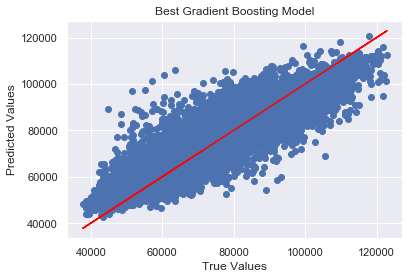

In [78]:
plt.scatter(ye_test, ye_preds_test)
plt.plot(ye_test, ye_test, color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Best Gradient Boosting Model")
plt.show()

In [85]:
# Calculate the improvement of the best grid search model over the base model.

print("Percent change from base to optimized model is:")
print("R-squared on training set: {:0.4f}%".format(100 * ((gs_r2_train - base_r2_train) / base_r2_train)))
print("R-squared on test set: {:0.4f}%".format(100 * ((gs_r2_test - base_r2_test) / base_r2_test)))
print("Mean Squared Error: {:0.4f}%".format(100 * ((gs_mse - base_mse) / base_mse)))
print("Root Mean Squared Error: {:0.4f}%".format(100 * ((gs_rmse - base_rmse) / base_rmse)))
print("Mean Absolute Error: {:0.4f}%".format(100 * ((gs_mae - base_mae) / base_mae)))


Percent change from base to optimized model is:
R-squared on training set: 19.3242%
R-squared on test set: 6.4432%
Mean Squared Error: -15.9630%
Root Mean Squared Error: -8.3283%
Mean Absolute Error: -9.2067%


## Conclusion:

By optimizing my base Gradient Boost model I was able to achieve an R-squared value of 0.7583 which is a 6.4% improvement over the base model. Although I was hoping to achieve a higher R-squared value the fact that I don't might also give an indication that there is something being overlook or an important factor that's missing from this analysis. 

Additional investigation into the specific outliers of this model might reveal a common set of factors that's affecting the model or perhaps there's an additional external factor that's missing from consideration. 

In my EDA I noticed that some of the largest variances in mean compensation were among the various school and district codes. I'm curious if the model is struggling to capture this variance due to the sheer number of schools and districts in Wisconsin. I had hoped that by bucketing the districts by per-pupil revenue might act as a proxy for this variance but there must be something else behind those hyper local variances. 

I found it reassuring to see that some factors I feared would influence teacher compensation, namely race and sex, appear to be non-factors. Other factors that I expected to impact compensation: grade level taught and subject area taught are surprisingly also non-factors. This hints to me that teaching in Wisconsin is not as open of a market as some believe. If you are a teacher of a high-needs area like STEM or SPED, you shouldn't expect your compensation to be affected. This also makes sense though in that this project looked specifically at traditional public school teachers, most of whom work for districts that have very rigid pay step systems. The compensation structure comes through in another way in the immense role that total experience plays.